# RuvB analysis based on elastic energy

In [1]:
import tools.load as load
import tools.spatial as spatial
import tools.sequence as seq
import tools.elastic as elastic

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import MultipleLocator
from matplotlib.animation import FuncAnimation
from matplotlib import rcParams
from matplotlib import cm
from matplotlib import animation

import seaborn as sns
from scipy.cluster.hierarchy import linkage

import warnings
import string
import time
from os import listdir as ls
from numba import jit

import pymol2
from pymol import stored

from scipy.stats import kruskal, mannwhitneyu, wilcoxon


#print(rcParams.keys())

WIDTH = 3+3/8
TICK_SIZE = 6
FONT_SIZE = 8
LEGEND_SIZE = 6
TITLE_SIZE = 8

plt.rc("font", size = FONT_SIZE)
plt.rc("figure", titlesize = TITLE_SIZE)
plt.rc("xtick", labelsize = TICK_SIZE)
plt.rc("ytick", labelsize = TICK_SIZE)
plt.rc("axes", titlesize = TITLE_SIZE, labelsize = FONT_SIZE)
plt.rc("legend", fontsize = LEGEND_SIZE, frameon = False)

axis_Eel = "Elastic energy, $E_{\\rm el}$ $(kT)$"
axis_Eel_short = "El. energy, $E_{\\rm el}$ $(kT)$"

## Loading

We begin by loading the polypeptides of all the structures

In [3]:
# Input
s_names = ['s0-At2', 's1t2', 's2t2', 's3t2', 's4t2', 's5t2']

# Set a vector to describe the chains names
chain_names = list(load.char_range('A','F'))[::-1]

# Compute
s_pps = []
for name in s_names:
    structure = load.single_structure(name, chain_ids=chain_names)
    s_pps.append(structure)

n = range(len(s_pps)-1)

## Structure labeling and visualization

In [4]:
states_names = ['s' + str(i+1) for i in n]
state_chain_names = []
state_chain_names_short = []
for name in chain_names:
    for i in n:
        state_chain_names.append(name + str(i+1))
        if i == 0:
            state_chain_names_short.append(name + str(i+1))
        else:
            state_chain_names_short.append("")

transition_names = [states_names[i] + ' > ' + states_names[(i+1)%len(n)] for i in n]

In [5]:
xyz_r, labels_r = load.coordinates_all_atoms(s_pps[0])

# Indexes of chains' atoms
chain_idx = load.chain_indices(chain_names, labels_r)
chain_colors = ["tab:red", "tab:purple", "tab:blue", "tab:green", "tab:olive", "tab:orange"]

chain_colors = chain_colors[::-1]

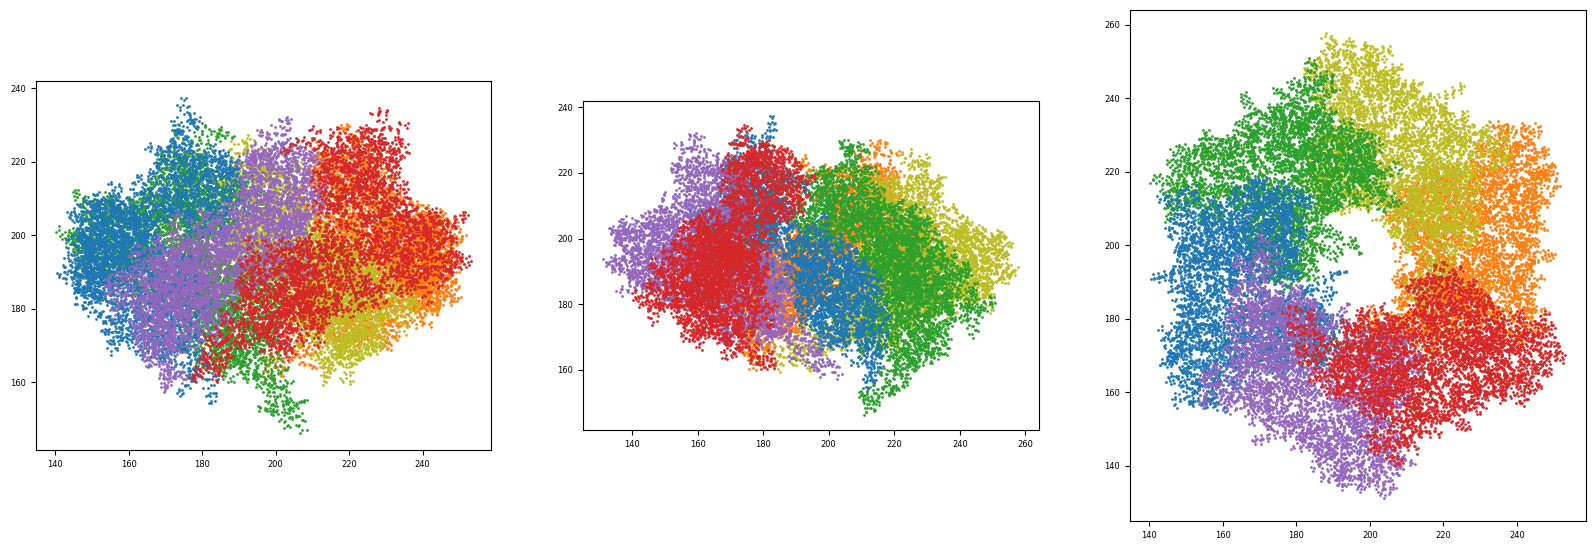

In [6]:
fig = plt.figure(figsize=(20, 10), dpi=100)
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

for idx, col in zip(chain_idx, chain_colors):
    xs, ys, zs = xyz_r[idx,0], xyz_r[idx,1], xyz_r[idx,2]

    ax1.scatter(xs, zs, s=1, color = col)
    ax2.scatter(ys, zs, s=1, color = col)
    ax3.scatter(xs, ys, s=1, color = col)

ax1.axis('scaled')
ax2.axis('scaled')
ax3.axis('scaled')
plt.show()

## Defining the set of common residues and common atoms

In [7]:
uni_ids = [None] * len([s_pps[0][3]])
indexes = []
labels_hex = []
labels_mon = []
labels_hex_at = []
labels_mon_at = []

# Compute
my_ref_seqs = seq.generate_reference([s_pps[0][3]], uni_ids)
for i in range(len(s_pps)):
    temp = dict()
    temp_at = dict()
    for j in range(len(s_pps[i])):
        temp2 = seq.aligned_dict([s_pps[i][j]], seq.align([s_pps[i][j]], my_ref_seqs))
        temp2_at = seq.aligned_dict_all_atoms([s_pps[i][j]], seq.align([s_pps[i][j]], my_ref_seqs))
        
        temp.update(temp2)
        temp_at.update(temp2_at)
        
        labels_mon.append(temp2)
        labels_mon_at.append(temp2_at)
    labels_hex.append(temp)
    labels_hex_at.append(temp_at)

com_res = seq.common(labels_mon[0], labels_mon[2])
com_at = seq.common_multiple([labels_mon_at[i] for i in range(6)])

## Loading atoms coordinates

In [8]:
# Get the position of all atoms
xyz = []
labels = []

for i in range(len(s_pps)):
    t1, t2 = load.coordinates_backbone(s_pps[i], com_at, labels_hex_at[i])
    xyz.append(t1)
    labels.append(t2)

chain_idx = load.chain_indices(chain_names, labels[0])

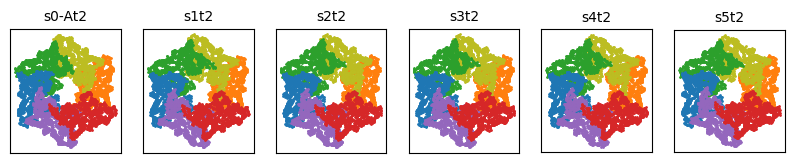

In [9]:
# Plot all structures
fig = plt.figure(figsize=(10, 12), dpi=100)

for i in range(len(s_pps)):
    ax = fig.add_subplot(1, len(s_pps), i+1)
    structure = labels[i][0][0][0]
    ax.set_title(structure, size = 10)
    
    chain_idx = load.chain_indices(chain_names, labels[i])
    for idx, col in zip(chain_idx, chain_colors):
        xs, ys, zs = xyz[i][idx,0], xyz[i][idx,1], xyz[i][idx,2]
        ax.scatter(xs, ys, s=1, color = col)
        
    ax.axis('scaled')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


## Elasticity calculations (cycle structures vs. reference structure)

In [10]:
warnings.filterwarnings('ignore')

F = np.zeros((len(s_pps)-1, len(xyz[0]), 3, 3))
F_dif = np.zeros((len(s_pps)-1, len(xyz[0]), 3, 3))
time1 = time.time()

# Calculate F with reference to s0-A(t2)

weights = elastic.intersect_nbhood_weights(xyz, parameters=[9])
for i in n:    
    structure_0 = labels[0][0][0][0]
    structure_i = labels[i+1][0][0][0]
    
    print("Computing weights and F for structures",
          structure_0, "and", structure_i)

    D, A = elastic.intermediate_matrixes(weights, xyz[0], xyz[i+1])
    F[i,:,:,:] = elastic.deformation_gradient(D, A)

time1 = time.time() - time1
print("Time:", time1)

Computing weights and F for structures s0-At2 and s1t2
Computing weights and F for structures s0-At2 and s2t2
Computing weights and F for structures s0-At2 and s3t2
Computing weights and F for structures s0-At2 and s4t2
Computing weights and F for structures s0-At2 and s5t2
Time: 18.29480218887329


## Calculating Strain energy density function $\Psi$

## $\Psi(\lambda_1, \lambda_2, \lambda_3) = \frac{\lambda}{2} \left[\sum\frac{{\lambda_i}^2 - 1}{2}\right]^2 + \mu \sum\left[\frac{{\lambda_i}^2-1}{2}\right]^2$

### $a = \left[\sum\frac{{\lambda_i}^2 - 1}{2}\right]^2$
### $b = \sum\left[\frac{{\lambda_i}^2-1}{2}\right]^2$
## $\Psi(\lambda_1, \lambda_2, \lambda_3) = \frac{\lambda}{2} a + \mu b $

In [11]:
time1 = time.time()
stretches = []
for i in n:
    gam_l, gam_n = elastic.lagrange_strain(F[i])
    st, st_axis = elastic.principal_stretches_from_g(gam_n)
    stretches.append(st)

stretches = np.abs(stretches)**0.5
a = np.sum((stretches**2-1)/2, axis = 2)**2
b = np.sum(((stretches**2-1)/2)**2, axis = 2)

lame_frst = 72976559.0446705 
lame_scnd = 37593984.96240601
psi = lame_frst/2 * a + lame_scnd * b

kT = 1.380649e-23*300

time1 = time.time() - time1
print("Time:", time1)

Time: 5.901893138885498


## Volume estimation of protomers

In [15]:
vdw = {"C":1.7e-10, "O":1.52e-10, "S":1.8e-10, "H":1.2e-10, "N":1.55e-10}
n_atom = {"C":0, "O":0, "S":0, "H":0, "N":0}
v_atom = {"C":0, "O":0, "S":0, "H":0, "N":0}

v = np.zeros(xyz[0].shape[0])

for i in range(len(v)):
    at = labels[0][i][1]
    
    v[i] = 4*np.pi*vdw[at]**3/3
    n_atom[at] += 1
    v_atom[at] += v[i]

for at in list(vdw.keys()):
    print(at + ": n =", n_atom[at], "\tv =", v_atom[at], "\tvf =", v_atom[at]/np.sum(v))

C: n = 3696 	v = 7.606192911651942e-26 	vf = 0.5759103600740639
O: n = 1848 	v = 2.718449940635405e-26 	vf = 0.20583010480267117
S: n = 0 	v = 0 	vf = 0.0
H: n = 0 	v = 0 	vf = 0.0
N: n = 1848 	v = 2.882608551687326e-26 	vf = 0.2182595351232384


In [16]:
vol_dir = "data/volume/"
files = np.array(ls(vol_dir))

c = 0

Vvdw, Vvoid = np.zeros(36), np.zeros(36)

for name in s_names:
    str_files = [file for file in files if name in file]
    for chain in chain_names:
        str_ch_file = [file for file in str_files if "_" + chain in file][0]
        with open(vol_dir + str_ch_file, "r") as f:
            line = f.readlines()[8].split(" ")
            line = np.array(line)
            line = line[line != '']
            
            Vvdw[c] = float(line[3].replace(",", "."))*1e-30
            Vvoid[c] = float(line[2].replace(",", "."))*1e-30
        c+=1
        
V = Vvdw + Vvoid

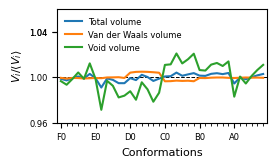

In [17]:
fig = plt.figure(figsize=(WIDTH*.8, 1.5), dpi=100)

order = (np.arange(36) % 6) * 6 + np.repeat(np.arange(6), 6)

ax = fig.add_subplot()
ax.plot(V[order]/np.mean(V), label = "Total volume")
ax.plot(Vvdw[order]/np.mean(Vvdw), label = "Van der Waals volume")
ax.plot(Vvoid[order]/np.mean(Vvoid), label = "Void volume")
ax.axhline(1, linestyle = "dashed", color = "black", zorder = -1, lw = .7)

ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_xticks(range(0, 36, 6), ["F0", "E0", "D0", "C0", "B0", "A0"])
ax.set_xlabel("Conformations")
ax.set_ylabel("$V_i/\\langle V_i \\rangle$")

ax.set_ylim(0.96, 1.06)
ax.set_xlim(-.6, 35.6)
ax.set_yticks([.96, 1, 1.04, 1.04])

ax.legend(ncol = 1, mode = "expand")
plt.show()



## Calculating integrated energy $E = \int\Psi dV$

In [18]:
V = V[6:]
Vvdw = Vvdw[6:]
Vvoid = Vvoid[6:]

E1, E2 = np.zeros(psi.shape), np.zeros(psi.shape)

c = 0
for i in range(5):
    for j, idx in zip(range(6), chain_idx):
        E1[i, idx] = Vvdw[c]/len(idx) * psi[i, idx]
        E2[i, idx] = Vvdw[c] * v[idx] * psi[i, idx] / np.sum(v[idx])
                
        c += 1


In [19]:
kT = 1.380649e-23*300
E = E2/kT

## Residue-wise energy calculation

In [20]:
# Subset the structure in domains
domain_names = ["$Head$", "$Small$", "$Large$", "$\\beta -hairpin$"]
domain_short = ["$H$", "$S$", "$L$", "$\\beta h$"]
domain_idx = [[],[],[],[]]
domain_colors = ["#97ebdb", "#00c2c7", "#0086ad", "#005582"][::-1]
domain_ranges = [range(253, 333),
                 range(182, 253), 
                 np.concatenate([range(0, 129), range(152, 182)]), 
                 range(129, 152)]


#labels_list = [i for i in labels_hex[0]]
labels_list = [i[0] for i in labels[0]]
for i in range(len(labels_list)):
    for j in range(len(domain_ranges)):
        if labels_list[i][3][1] in domain_ranges[j]:
            domain_idx[j].append(i) 

domain_aa_res = [[],[],[],[]]
domain_aa_col = [[],[],[],[]]
domain_aa_idx = [[],[],[],[]]

c=0
sequence = s_pps[0][0][0].get_sequence()
for aa in s_pps[0][0][0]:
    for j in range(len(domain_ranges)):
        if aa.get_id()[1] in domain_ranges[j]:
            domain_aa_res[j].append(sequence[c])
            domain_aa_idx[j].append(aa.get_id()[1])
            domain_aa_col[j].append(domain_colors[j])
            
    c+=1

def unlist(l):
    ul = []
    for i in l:
        ul += i
    return ul

residues_code = unlist(domain_aa_res)
residues_domain_col = unlist(domain_aa_col)
residues_idx = unlist(domain_aa_idx)

residues_code = [x for _, x in sorted(zip(residues_idx, residues_code))]
residues_domain_col = [x for _, x in sorted(zip(residues_idx, residues_domain_col))]
residues_idx.sort()

In [21]:
conserved = ' ::*    :: *:      : : : .:  .     * :: ****:***::: : :  :        .  : :  *:   :  :   .::*:**** :     * :  .:: : ::  :. .  :    : :  *: :****: * :  *:  **..  ..  *   ::   :   .  :           :   :: * *:* .: : : :   :     :        :        *::  *   *  :       * *   :.         :.:  **:*:  . : :*  **  *      :        '
conserved_dict = {}
mutated = '--B---------B-----B----------A--------------B-AA---------------------DBB-----A-------------A--A-------A-----BCB-------A-C---B-C-C----B---BAAB----A--DA--AB-B-A--BAA---D----------------------------A-B-A---A--DA-A-A--B-----------------A--B-------D-DB-A-------A-A---------------D-B---A-A--------A--AAA------------------'
mutated_dict = {}

In [22]:
# nans (residues that were excluded in the process of sequence alignment)

non_nans = np.unique([labels[0][i][0][3][1] for i in range(xyz[0].shape[0])])
non_nans = set(non_nans)
all_res = set(residues_idx)
nans = all_res.difference(non_nans)

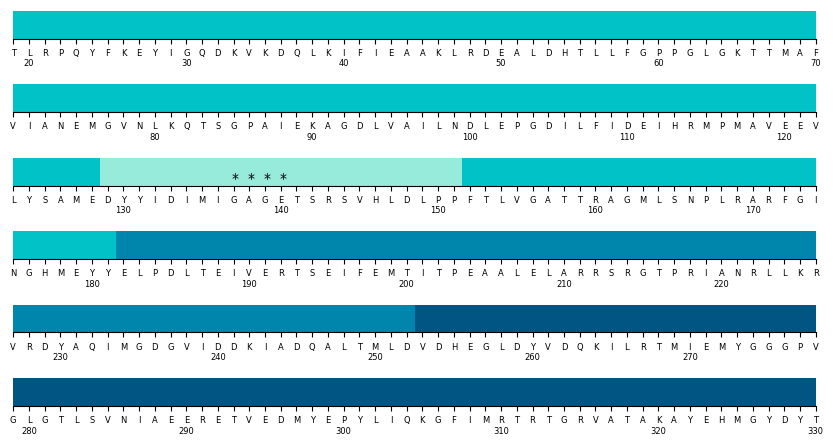

In [23]:
fig = plt.figure(figsize=(WIDTH*2.5, 5), dpi=100)

ticks_number = []
for i in residues_idx:
    if i % 10 == 0:
        ticks_number.append("\n" + str(i))
    else:
        ticks_number.append("")

c = 0
for i, col in zip(residues_idx, residues_domain_col):
    if c % 52 == 0:
        ax = fig.add_subplot(7, 1, c//52 + 1)
        
        ax.set_xticks(range(0,52))
        ax.set_xticklabels([residues_code[j] + ticks_number[j] for j in range(c, c+52)])
        ax.set_yticks([])
        ax.set_xlim([0, 51])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
    
    ax.bar(c%52, 1, color = col, width = 1)
    if i in nans:
        ax.text(s = "*", x = c % 52 -.1, y = .1, color = "black")
        
    c+=1

plt.tight_layout()

## MSA and mutagenesis

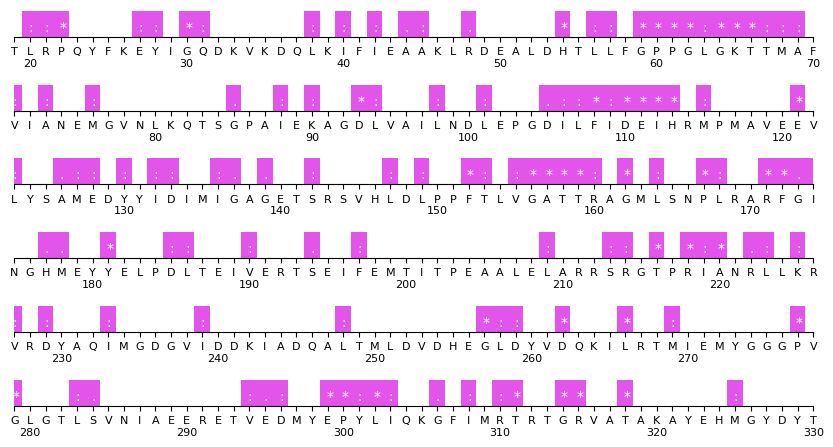

In [24]:
fig = plt.figure(figsize=(WIDTH*2.5, 5), dpi=100)

ticks_number = []
for i in residues_idx:
    if i % 10 == 0:
        ticks_number.append("\n" + str(i))
    else:
        ticks_number.append("")

c = 0
for i, col in zip(residues_idx, residues_domain_col):
    if c % 52 == 0:
        ax = fig.add_subplot(7, 1, c//52 + 1)
        
        ax.set_xticks(range(0,52))
        ax.set_xticklabels([residues_code[j] + ticks_number[j] for j in range(c, c+52)], fontsize = 8)
        ax.set_yticks([])
        ax.set_xlim([0, 51])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
    
    if conserved[c] == " ":
        ax.bar(c%52, 1, color = "white", width = 1)
    else:
        ax.bar(c%52, 1, color = "#e355ea", width = 1)
        
    ax.text(s = conserved[c], x = c % 52 -.1, y = .1, color = "white", 
            verticalalignment = "bottom")
    conserved_dict[i] = conserved[c]
        
    c+=1

plt.tight_layout()

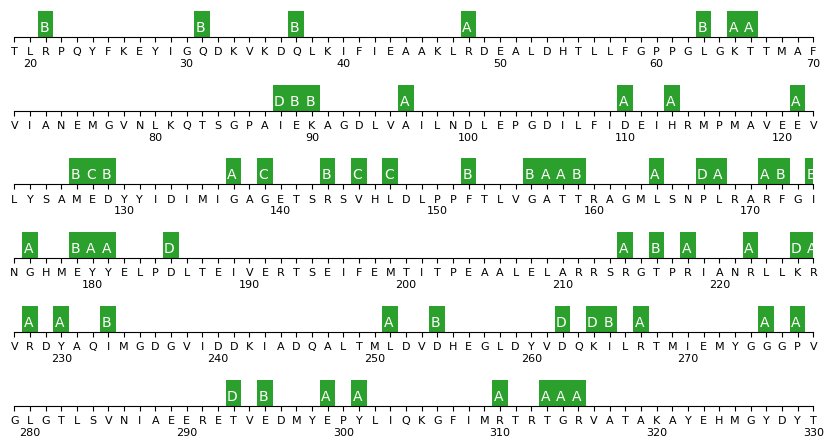

In [25]:
fig = plt.figure(figsize=(WIDTH*2.5, 5), dpi=100)

ticks_number = []
for i in residues_idx:
    if i % 10 == 0:
        ticks_number.append("\n" + str(i))
    else:
        ticks_number.append("")

c = 0
for i, col in zip(residues_idx, residues_domain_col):
    if c % 52 == 0:
        ax = fig.add_subplot(7, 1, c//52 + 1)
        
        ax.set_xticks(range(0,52))
        ax.set_xticklabels([residues_code[j] + ticks_number[j] for j in range(c, c+52)], fontsize = 8)
        ax.set_yticks([])
        ax.set_xlim([0, 51])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
    
    if mutated[c] == "-":
        ax.bar(c%52, 1, color = "white", width = 1)
    else:
        ax.bar(c%52, 1, color = "tab:green", width = 1)
        
    ax.text(s = mutated[c], x = c % 52 -.1, y = .1, color = "white", 
            verticalalignment = "bottom", horizontalalignment = "center")
    mutated_dict[i] = mutated[c]
        
    c+=1

plt.tight_layout()

In [26]:
# removing nans
residues_code = [residues_code[i] for i in range(len(residues_idx)) if residues_idx[i] in non_nans]
residues_domain_col = [residues_domain_col[i] for i in range(len(residues_idx)) if residues_idx[i] in non_nans]
residues_idx = [residues_idx[i] for i in range(len(residues_idx)) if residues_idx[i] in non_nans]
conserved = [conserved_dict[i] for i in residues_idx]
mutated = [mutated_dict[i] for i in residues_idx]

In [27]:
residues_energy = np.zeros((len(residues_idx), len(chain_names), len(s_names)-1))
residues_pos = np.zeros((len(residues_idx), 3))

for i in range(len(labels[0])):
    for k in range(len(s_names)-1):
        resi = labels[0][i][0][3][1]
        chain = labels[0][i][0][2]
        i_ = residues_idx.index(resi)
        j_ = chain_names.index(chain)

        residues_energy[i_, j_, k] += E[k, i]
        
        if labels[0][i][0][4][0] == "CA":
            residues_pos[i_] = xyz[0][i]
            
residues_energy[residues_energy == 0] = np.nan
residues_energy_resh = residues_energy.reshape((len(residues_idx), len(chain_names) * (len(s_names)-1)))
residues_energy_med = np.median(residues_energy_resh, axis = 0)

## Summary statistics per residue

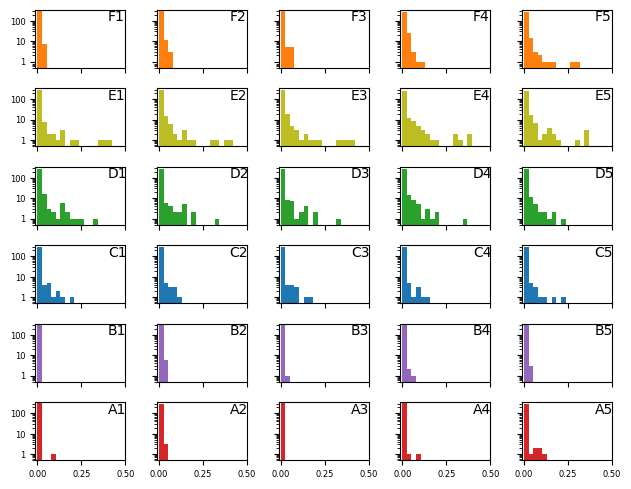

In [28]:
fig = plt.figure(figsize = (1.9*WIDTH, 5), dpi = 100)

c = 0
for j in range(len(chain_names)):
    if j == 5:
        xticks = ["0.00", "0.25", "0.50"]
    else:
        xticks = [""] * 3    
        
    for i in range(5):
        if i == 0:
            yticks = ["1", "10", "100"]
        else:
            yticks = [""] * 3
    
        c += 1
        ax = fig.add_subplot(6, 5, c)
        ax.hist(residues_energy_resh[:, j*5+i], bins = np.linspace(0, 0.5, 20), 
                color = chain_colors[j], log = True)
        
        
        ax.text(0.4, 100, chain_names[j] + str(i+1))
        ax.set_xticks([0, 0.25, 0.5], xticks)
        ax.set_yticks([1, 10, 100], yticks)
        
        ax.set_xlim(-0.01, 0.5)
        ax.set_ylim(0.5, 350)

plt.tight_layout()

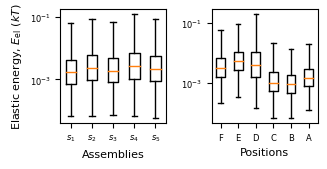

In [29]:
fig = plt.figure(figsize = (WIDTH, 1.8), dpi = 100)

ax = fig.add_subplot(1,2,1)
ax.set_xlabel("Assemblies")
ax.set_ylabel(axis_Eel)
ax.boxplot([np.log10(residues_energy_resh[:, [j*5+i for j in range(6)]]).flatten() for i in range(5)], 
           showfliers = False)
ax.set_xticklabels(["$s_" + str(i) + "$" for i in range(1, 6)])
ax.set_yticks([-3, -1], ["$10^{-3}$", "$10^{-1}$"])

ax = fig.add_subplot(1,2,2)
ax.set_xlabel("Positions")
ax.boxplot([np.log10(residues_energy_resh[:, (5*i):(5*(i+1))].flatten()) for i in range(6)], 
           showfliers = False)
ax.set_xticklabels(chain_names)
ax.set_yticks([-3, -1], ["$10^{-3}$", "$10^{-1}$"])

plt.tight_layout()

## Global energy calculations

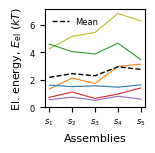

In [30]:
fig = plt.figure(figsize=(1.3, 1.3), dpi=100)

ax = fig.add_subplot(1, 1, 1)

for idx, col, name in zip(chain_idx, chain_colors, chain_names):
    #ax.scatter(n, np.sum(E[:, idx], axis=1), c = col, s = 10)
    ax.plot(n, np.sum(E[:, idx], axis=1), c = col, lw = .8)
ax.plot(n, np.sum(E, axis=1)/6, c = "black", linestyle = "--", linewidth = 1, label = "Mean")

ax.legend()
ax.set_xticks(range(5), ["$s_" + str(i) + "$" for i in range(1, 6)])
ax.set_yticks([0, 2, 4, 6])
ax.set_xlabel("Assemblies")
ax.set_yticklabels([0, 2, 4, 6])
ax.set_ylabel(axis_Eel_short)


plt.show()


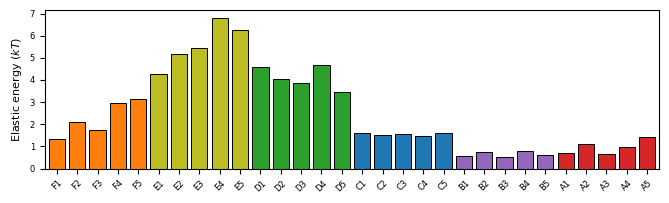

In [31]:
fig = plt.figure(figsize=(WIDTH*2.35, 2.1), dpi=100)

ax = fig.add_subplot(1, 1, 1)
e_landscape = np.zeros(30) 

for idx, col, name, i in zip(chain_idx, chain_colors, chain_names, range(len(chain_idx))):
    ax.bar(range(i*(len(n)), (i+1)*len(n)), np.sum(E[:, idx], axis=1), 
           label = name, color = col,
           lw = 0.7, edgecolor = "black")
    e_landscape[range(i*len(n), (i+1)*len(n))] = np.sum(E[:, idx], axis=1)

ax.set_ylabel("Elastic energy ($kT$)")

ax.set_xticklabels(state_chain_names, rotation = 45)
ax.set_xticks(range(len(state_chain_names)))
ax.set_xlim(-.6, 29.6)

plt.show()

In [32]:
with open("energy_landscape.npy", "wb") as f:
    np.save(f, e_landscape)

# Partition of energy per domain

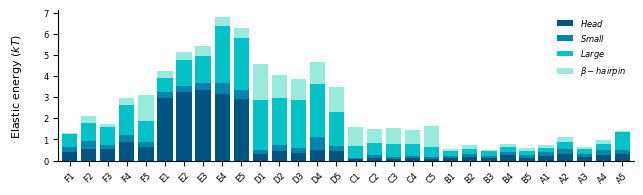

In [33]:
fig = plt.figure(figsize=(WIDTH*2.2, 2), dpi=100)

fig.supylabel("Elastic energy ($kT$)", fontsize = 8, x = 0.06)

ax = fig.add_subplot(1, 1, 1)

for c_idx, i in zip(chain_idx, range(len(chain_idx))):
    previous = np.zeros(len(n))
    for d_idx, d_name, d_col in zip(domain_idx, domain_names, domain_colors):
        idx = list(set(c_idx).intersection(set(d_idx)))
        current = np.sum(E[:, idx], axis=1)
        
        ax.bar(range(i*(len(n)), (i+1)*len(n)), 
               current, 
               bottom = previous, 
               color = d_col)
        previous += current

ax.legend(domain_names)

ax.set_xticklabels(state_chain_names, rotation = 45)
ax.set_xticks(range(len(state_chain_names)))
ax.set_xlim(-.6, 29.6)


#ax.set_yticks([0, 0.5, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    

plt.show()


# Finding mechanically active regions (variance threshold)

T19 0
L20 1
R21 2
Y124 105
S125 106
D133 114
I134 115
M135 116
T141 118
S142 119
R143 120
S144 121
V145 122
H146 123
L147 124
R160 137
A161 138
G162 139
R192 169
G279 256
G281 258
T282 259
L283 260
S284 261
V285 262
N286 263
I287 264
A288 265
E289 266
E292 269
R310 287


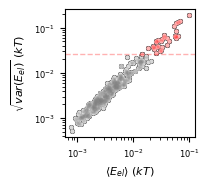

In [35]:
fig = plt.figure(figsize = (WIDTH/2, WIDTH/2), dpi = 100)

size = 10

def fancy_scatter(ax, xdata, ydata, color, size, lw, alpha):
    ax.scatter(xdata, ydata, color = "black", s = size, lw = lw)
    ax.scatter(xdata, ydata, color = "white", s = size, lw = 0)
    ax.scatter(xdata, ydata, color = color, s = size, lw = 0, alpha = alpha)
    return

ax = fig.add_subplot(1,1,1)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel("$\sqrt{var(E_{el})}$ $(kT)$")
ax.set_xlabel("$\\langle E_{el} \\rangle$ $(kT)$")


fancy_scatter(ax,
              np.mean(residues_energy_resh, axis = 1),
              np.std(residues_energy_resh, axis = 1),
              color = "gray", size = size, alpha = .3, lw = 0.5)

var_trsh = np.quantile(np.std(residues_energy_resh, axis = 1), 0.9)

mech_active = np.std(residues_energy_resh, axis = 1) > var_trsh

fancy_scatter(ax,
              np.mean(residues_energy_resh[mech_active], axis = 1),
              np.std(residues_energy_resh[mech_active], axis = 1),
              color = "red", size = size, alpha = .3, lw = 0.5)

ax.axhline(var_trsh, lw = 1, ls = "dashed", color = "red", alpha = .3)

for i in range(len(mech_active)):
    if mech_active[i]:
        print(residues_code[i] + str(residues_idx[i]), i)


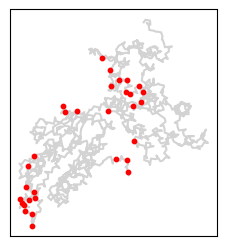

In [36]:
fig = plt.figure(figsize = (3, 3), dpi = 100)

# plotting structure coordinates
ys, zs = xyz[0][chain_idx[0],1], xyz[0][chain_idx[0],2]
ax = fig.add_subplot(1,1,1)
ax.plot(ys, zs, color = "lightgray", zorder = -1)


ys_res, zs_res = residues_pos[mech_active,1], residues_pos[mech_active,2]
ax.scatter(ys_res, zs_res, s = 10, color = "red")
    
ax.set_xticks([])
ax.set_yticks([])
ax.axis("scaled")


plt.show()

<Figure size 300x300 with 0 Axes>

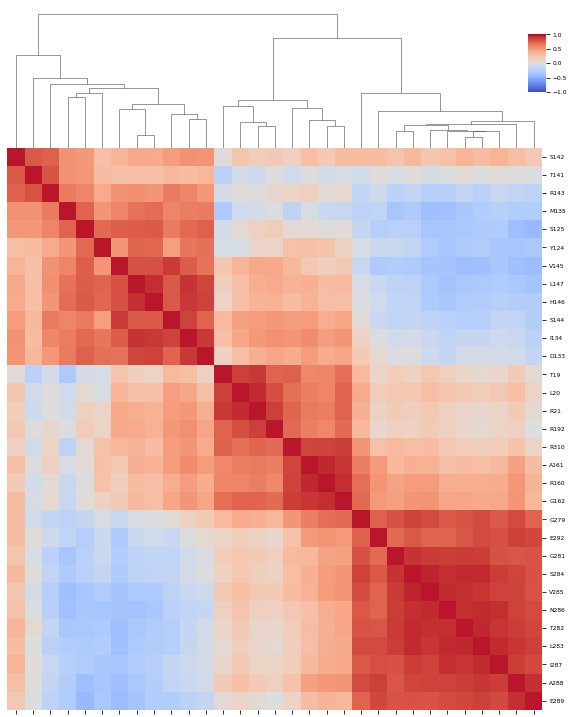

In [38]:
plt.figure(figsize = (3,3), dpi = 100)

mech_active_idx = np.where(mech_active)[0]

def plot_matrix(matrix, cmap = "viridis"):
    link = linkage(matrix.T, 
                   optimal_ordering = True)

    plot = sns.clustermap(matrix.T, 
                          row_linkage = link, 
                          col_linkage = link,
                          figsize = (8,10),
                          cmap = cmap,
                          cbar_pos=(0.92, .87, .03, .08),
                          dendrogram_ratio = (0, .2),
                          vmin = -1, vmax = 1)
    
    plot.savefig("mechanically_active.svg")


cov_matrix = np.zeros((sum(mech_active), sum(mech_active)))

residues_energy_resh_log = np.log(residues_energy_resh)
residues_energy_mean = np.mean(residues_energy_resh_log, axis = 1)
residues_energy_std = np.std(residues_energy_resh_log, axis = 1)

for i in range(sum(mech_active)):
    a = mech_active_idx[i]
    for j in range(sum(mech_active)):
        b = mech_active_idx[j]
        
        cov_matrix[i, j] = sum((residues_energy_resh_log[a] - residues_energy_mean[a]) * (residues_energy_resh_log[b] - residues_energy_mean[b])) / sum(mech_active)
        cov_matrix[i, j] /= (residues_energy_std[a] * residues_energy_std[b])

mech_active_label = [residues_code[i] + str(residues_idx[i]) for i in mech_active_idx]

cov_matrix = pd.DataFrame(cov_matrix, 
                          columns = mech_active_label, 
                          index = [""]*31)

plot_matrix(cov_matrix, "coolwarm")


# Selecting the four regions

In [39]:
def pymol_color_fmt(color):
    color = [int(c*255) for c in color]
    return '0x{:02x}{:02x}{:02x}'.format(*color)

def rgba_to_hexa(color):
    color = [int(c*255) for c in color]
    return '#{:02x}{:02x}{:02x}{:02x}'.format(*color)

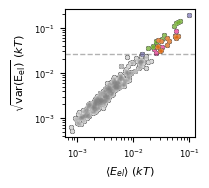

In [40]:
fig = plt.figure(figsize = (WIDTH/2, WIDTH/2), dpi = 100)

size = 10

def fancy_scatter(ax, xdata, ydata, color, size, lw, alpha):
    ax.scatter(xdata, ydata, color = "black", s = size, lw = lw)
    ax.scatter(xdata, ydata, color = "white", s = size, lw = 0)
    ax.scatter(xdata, ydata, color = color, s = size, lw = 0, alpha = alpha)
    return

ax = fig.add_subplot(1,1,1)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel("$\sqrt{\\rm{var}(E_{el})}$ $(kT)$")
ax.set_xlabel("$\\langle E_{el} \\rangle$ $(kT)$")


fancy_scatter(ax,
              np.mean(residues_energy_resh, axis = 1),
              np.std(residues_energy_resh, axis = 1),
              color = "gray", size = size, alpha = .3, lw = 0.5)

var_trsh = np.quantile(np.std(residues_energy_resh, axis = 1), 0.9)

mech_active_reg = [[0, 1, 2, 169],
                   [137, 138, 139, 287],
                   [256, 258, 259, 260, 261, 262, 263, 264, 265, 266, 269],
                   [105, 106, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124]]

mech_active_cmap = cm.get_cmap("Dark2", 8)
mech_active_colors = [rgba_to_hexa(mech_active_cmap(i)) for i in [2,3,4,1]]

ax.axhline(var_trsh, lw = 1, ls = "dashed", color = "black", alpha = .3)

for i in range(len(mech_active_reg)):
    fancy_scatter(ax,
                  np.mean(residues_energy_resh[mech_active_reg[i]], axis = 1),
                  np.std(residues_energy_resh[mech_active_reg[i]], axis = 1),
                  color = mech_active_colors[i], size = size, alpha = .7, lw = 0.5)
    

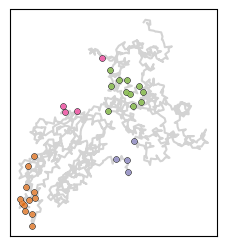

In [41]:
fig = plt.figure(figsize = (3, 3), dpi = 100)

# plotting structure coordinates
ys, zs = xyz[0][chain_idx[0],1], xyz[0][chain_idx[0],2]
ax = fig.add_subplot(1,1,1)
ax.plot(ys, zs, color = "lightgray", zorder = -1)
    

for i in range(len(mech_active_reg)):
    ys_res, zs_res = residues_pos[mech_active_reg[i],1], residues_pos[mech_active_reg[i],2]
    fancy_scatter(ax, ys_res, zs_res, mech_active_colors[i], 15, .7, .7)
    
ax.set_xticks([])
ax.set_yticks([])
ax.axis("scaled")


plt.show()

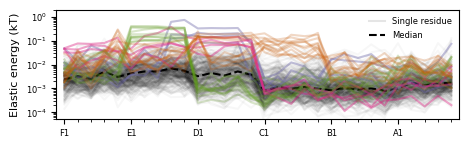

In [42]:
fig = plt.figure(figsize=(5.2, 1.45), dpi=100)

ax = fig.add_subplot(1, 1, 1)
ax.set_ylabel("Elastic energy (kT)")
ax.set_yscale("log")


for i in range(len(residues_idx)):
    ax.plot(residues_energy_resh[i], alpha = 0.03, 
            color = "black")
    
ax.plot(np.median(residues_energy_resh, axis = 0),  
        color = "black", linestyle = "dashed")

ax.plot(np.nan, alpha = 0.1, color = "black", label = "Single residue")
ax.plot(np.nan, color = "black", linestyle = "dashed", label = "Median")
ax.legend(frameon = False, ncol = 1, loc = "upper right")

alphas = [0.4, 0.4, 0.2, 0.2]
for i in range(len(mech_active_reg)):
    for j in range(len(mech_active_reg[i])):
        ax.plot(residues_energy_resh[mech_active_reg[i][j]], 
                color = mech_active_colors[i], 
                alpha = alphas[i])

ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax.set_ylim(5e-5, 2e0)
#ax.set_xlim(0, 29)
ax.set_xlim(-.6, 29.6)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_xticks(range(0, 30, 5), 
              state_chain_names_short[0:30:5])

        
plt.show()

In [44]:
pymol_colors = [pymol_color_fmt(mech_active_cmap(i)) for i in [2,3,4,1]]

for i in range(len(mech_active_reg)):
    for j in mech_active_reg[i]:
        print("select resi " + str(residues_idx[j]))
        print("color " + pymol_colors[i] + ", (sele)")


select resi 19
color 0x7570b3, (sele)
select resi 20
color 0x7570b3, (sele)
select resi 21
color 0x7570b3, (sele)
select resi 192
color 0x7570b3, (sele)
select resi 160
color 0xe7298a, (sele)
select resi 161
color 0xe7298a, (sele)
select resi 162
color 0xe7298a, (sele)
select resi 310
color 0xe7298a, (sele)
select resi 279
color 0x66a61e, (sele)
select resi 281
color 0x66a61e, (sele)
select resi 282
color 0x66a61e, (sele)
select resi 283
color 0x66a61e, (sele)
select resi 284
color 0x66a61e, (sele)
select resi 285
color 0x66a61e, (sele)
select resi 286
color 0x66a61e, (sele)
select resi 287
color 0x66a61e, (sele)
select resi 288
color 0x66a61e, (sele)
select resi 289
color 0x66a61e, (sele)
select resi 292
color 0x66a61e, (sele)
select resi 124
color 0xd95f02, (sele)
select resi 125
color 0xd95f02, (sele)
select resi 133
color 0xd95f02, (sele)
select resi 134
color 0xd95f02, (sele)
select resi 135
color 0xd95f02, (sele)
select resi 141
color 0xd95f02, (sele)
select resi 142
color 0xd95f

In [45]:
std_cmap = cm.get_cmap("viridis_r", 10)
std_norm = colors.Normalize(vmin = 0, 
                            vmax = max(np.std(residues_energy_resh, axis = 1))*.5)

pymol_colors = [pymol_color_fmt(std_cmap(std_norm(np.std(residues_energy_resh[i])))) for i in range(len(residues_idx))]
for i in range(len(residues_idx)):
    print("select resi " + str(residues_idx[i]))
    print("color " + pymol_colors[i] + ", (sele)")


select resi 19
color 0x30678d, (sele)
select resi 20
color 0x440154, (sele)
select resi 21
color 0x30678d, (sele)
select resi 22
color 0x6dce58, (sele)
select resi 23
color 0xb5dd2b, (sele)
select resi 24
color 0xfde724, (sele)
select resi 25
color 0xfde724, (sele)
select resi 26
color 0xfde724, (sele)
select resi 27
color 0xfde724, (sele)
select resi 28
color 0xfde724, (sele)
select resi 29
color 0xfde724, (sele)
select resi 30
color 0xfde724, (sele)
select resi 31
color 0xfde724, (sele)
select resi 32
color 0xfde724, (sele)
select resi 33
color 0xfde724, (sele)
select resi 34
color 0xfde724, (sele)
select resi 35
color 0xfde724, (sele)
select resi 36
color 0xfde724, (sele)
select resi 37
color 0xfde724, (sele)
select resi 38
color 0xfde724, (sele)
select resi 39
color 0xfde724, (sele)
select resi 40
color 0xfde724, (sele)
select resi 41
color 0xfde724, (sele)
select resi 42
color 0xfde724, (sele)
select resi 43
color 0xfde724, (sele)
select resi 44
color 0xfde724, (sele)
select resi 

# Interactions from pymol

In [46]:
# function modified from https://raw.githubusercontent.com/Pymol-Scripts/Pymol-script-repo/master/plugins/show_contacts.py

def show_contacts(selection, selection2, pymol, cutoff=3.6, bigcutoff = 4.0):

    pymol_out = {'polar': [],
                 'hbond': [],
                 'non_optimal': []}

    pairs = pymol.cmd.find_pairs(selection, selection2, mode = 0, cutoff=bigcutoff)
    
    if pairs == []:
        return pymol_out
    
    s1 = "(index " + str(pairs[0][0][1])
    s2 = "(index " + str(pairs[0][1][1])
    for i in range(1, len(pairs)):
        s1 += " or index " + str(pairs[i][0][1])
        s2 += " or index " + str(pairs[i][1][1])
    
    
    # ensure only N and O atoms are in the selection
    all_don_acc1 = s1 + ") and (donor or acceptor)"
    all_don_acc2 = s2 + ") and (donor or acceptor)"
    
    #if theses selections turn out not to have any atoms in them, pymol throws cryptic errors when calling the dist function like:
    #'Selector-Error: Invalid selection name'
    #So for each one, manually perform the selection and then pass the reference to the distance command and at the end, clean up the selections
    #the return values are the count of the number of atoms
    all1_sele_count = pymol.cmd.select('all_don_acc1_sele', all_don_acc1)
    all2_sele_count = pymol.cmd.select('all_don_acc2_sele', all_don_acc2)
        
                    
    ########################################
    #compute good polar interactions according to pymol
    if all1_sele_count and all2_sele_count:
        for at1 in pymol.cmd.index('all_don_acc1_sele'):
            for at2 in pymol.cmd.index('all_don_acc2_sele'):
                if pymol.cmd.distance(None, at1, at2, cutoff, mode = 2):
                    pymol.cmd.iterate(at2, 'polar.append([chain, resn, resi, name])', space=pymol_out)

                    
    ########################################
    #When running distance in mode=2, the cutoff parameter is ignored if set higher then the default of 3.6
    #so set it to the passed in cutoff and change it back when you are done.
    pymol.cmd.set('h_bond_cutoff_center', bigcutoff)
    pymol.cmd.set('h_bond_cutoff_edge', bigcutoff)
        
    #compute possibly suboptimal polar interactions using the user specified distance
    if all1_sele_count and all2_sele_count:
        for at1 in pymol.cmd.index('all_don_acc1_sele'):
            for at2 in pymol.cmd.index('all_don_acc2_sele'):
                if pymol.cmd.distance(None, at1, at2, bigcutoff, mode = 2):
                    pymol.cmd.iterate(at2, 'non_optimal.append([chain, resn, resi, name])', space=pymol_out)

    
    ########################################
    onlyacceptors1 = s1 + ") and (acceptor and !donor)"
    onlyacceptors2 = s2 + ") and (acceptor and !donor)"
    onlydonors1 = s1 + ") and (!acceptor and donor)"
    onlydonors2 = s2 + ") and (!acceptor and donor)"  
    
    #perform the selections
    onlyacceptors1_sele_count = pymol.cmd.select('onlyacceptors1_sele', onlyacceptors1)
    onlyacceptors2_sele_count = pymol.cmd.select('onlyacceptors2_sele', onlyacceptors2)
    onlydonors1_sele_count = pymol.cmd.select('onlydonors1_sele', onlydonors1)
    onlydonors2_sele_count = pymol.cmd.select('onlydonors2_sele', onlydonors2)            
    
    if onlyacceptors1_sele_count and onlyacceptors2_sele_count:
        for at1 in pymol.cmd.index('onlyacceptors1'):
            for at2 in pymol.cmd.index('onlyacceptors2'):
                if pymol.cmd.distance(None, at1, at2, cutoff, mode = 0):
                    pymol.cmd.iterate(at2, 'hbond.append([chain, resn, resi, name])', space=pymol_out)
    
    ########################################
    if onlydonors1_sele_count and onlydonors2_sele_count:
        for at1 in pymol.cmd.index('onlydonors1'):
            for at2 in pymol.cmd.index('onlydonors2'):
                if pymol.cmd.distance(None, at1, at2, cutoff, mode = 0):
                    pymol.cmd.iterate(at2, 'hbond.append([chain, resn, resi, name])', space=pymol_out)

    
    return pymol_out


# All inter and intramolecular interactions

In [47]:
interactions = np.load("Pymol/interactions.npy", allow_pickle = True)
interactions_s0 = np.load("Pymol/interactions_s0.npy", allow_pickle = True)
interaction_types = ["H bonds", "Polar", "Polar non opt", "All"]
interaction_colors = ["#4E5DC0", "#E84A5F", "#F1929F", "#8E7CC3"]

repeated_chain_names = np.repeat(chain_names, 5).tolist()
interactions.shape

(308, 30, 3)

In [48]:
interactions_s0.shape

(308, 6, 3)

# Inter and intramolecular interactions

# Interactions per type (H bonds, polar)

In [49]:
#0: same chain
#1: chain + 1
#2: chain - 1
#3: ruvA
#4: dna
#5: nucleotide
#6: magnesium
interacts_with_names = ["Cis", "Forward\nposition", "Backward\nposition", "RuvA", "DNA", "Nucleotide", "$Mg^{2+}$"]
interacts_with = np.zeros((7, 30, 3))
interacts_with_energy = np.zeros((7, 30, 3))
interacts_with_res = [[] for i in range(7)]

doesnt_interact = np.zeros(30)
doesnt_interact_energy = np.zeros(30)
repeated_chain_names = np.repeat(chain_names, 5).tolist()

for k in range(3):
    for i in range(len(residues_idx)):
        for j in range(residues_energy_resh.shape[1]):
            interaction_list = interactions[i, j, k]
            
            n_inter = 0
            for inter in interactions[i, j]:
                n_inter += len(inter)
            
            if n_inter == 0:
                doesnt_interact[j] += 1/3
                doesnt_interact_energy[j] += residues_energy_resh[i, j]/3
                
            for l in interaction_list:
                if l[0] == repeated_chain_names[j]:
                    c = 0
                elif l[0] == chain_names[(j//5 + 1) % 6]:
                    c = 1
                elif l[0] == chain_names[(j//5 - 1) % 6]:
                    c = 2
                elif l[0] in ["G", "H"]:
                    c = 3
                elif l[0] in ["U", "V"]:
                    c = 4
                elif l[0] in ["I", "J", "K", "L", "M", "N"]:
                    c = 5
                elif l[0] == "O":
                    c = 6
                else:
                    print(l[0], repeated_chain_names[j])
            
                interacts_with[c, j, k] += 1
                interacts_with_res[c].append(i)
                interacts_with_energy[c, j, k] += residues_energy_resh[i, j]/n_inter            

for i in range(len(interacts_with_names)):
    interacts_with_res[i] = np.unique(interacts_with_res[i])

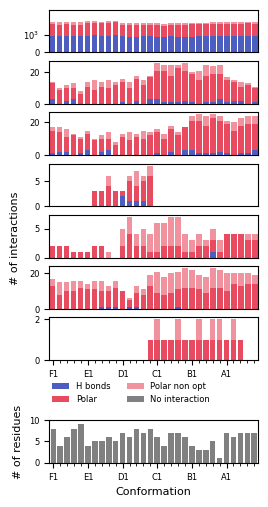

In [51]:
fig = plt.figure(figsize = (WIDTH*.8, 6), dpi = 100)

for i in range(interacts_with_energy.shape[0]):
    ax = fig.add_subplot(interacts_with_energy.shape[0] + 2, 1, i+1)
    
    prev = np.zeros(30)
    for j in range(3):
        ax.bar(range(30), interacts_with[i, :, j], 
               bottom = prev, 
               label = interaction_types[j], 
               color = interaction_colors[j])
        prev += interacts_with[i, :, j]
    #ax.set_ylabel(interacts_with_names[i])
    ax.set_xticks([])
    ax.set_xlim(-.5, 29.5)
    
    if i == 0:
        ax.set_ylim(0, 2400)
        ax.set_yticks([0, 1000], ["0", "10$^3$"])
    elif i == 6:
        ax.set_xlim(-.6, 29.6)
        ax.xaxis.set_minor_locator(MultipleLocator(1))
        ax.set_xticks(range(0, 30, 5), 
              state_chain_names_short[0:30:5])
        
        ax.bar(np.nan, np.nan, color = "gray", label = "No interaction")

        
ax.legend(loc = (0, -1.1), ncol = 2)
fig.supylabel("# of interactions", fontsize = 8, x = -.02)    

ax = fig.add_subplot(interacts_with_energy.shape[0] + 2, 1, 9)
ax.set_ylabel("# of residues")
ax.set_yticks([0, 5, 10])
ax.set_ylim(0, 10)
ax.bar(range(30), doesnt_interact, color = "gray")

ax.set_xticklabels(state_chain_names_short)
ax.set_xlim(-.6, 29.6)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_xticks(range(0, 30, 5), 
              state_chain_names_short[0:30:5])
ax.set_xlabel("Conformation")


plt.show()

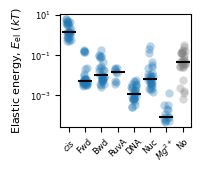

In [52]:
fig = plt.figure(figsize = (WIDTH/2, 1.5), dpi = 100)

ax = fig.add_subplot(1, 1, 1)

interacts_with_cmap = plt.colormaps["Dark2"]
for i in range(7):
    ax.scatter(i*np.ones(30) + np.random.rand(30)*.3, 
                np.sum(interacts_with_energy[i, :, :], axis = 1), 
                alpha = 0.3, lw = 0, color = "C0")
    
    
    mean = np.mean(np.sum(interacts_with[i, :, :], axis = 1))
    if i == 0:
        mean = int(np.round(mean))
    else:
        mean = np.round(mean, 1)
    
    ax.scatter(i + .15, 
               np.median([i for i in np.sum(interacts_with_energy[i, :, :], axis = 1) if i != 0]),
               color = "black", marker = "_", s = 100)
    

ax.scatter(7 * np.ones(30) + np.random.rand(30) * .3, 
            doesnt_interact_energy, 
            color = "gray", alpha = 0.3, lw = 0)
    
ax.scatter(7 + .15, 
            np.median(doesnt_interact_energy), 
            color = "black", marker = "_", s = 100)

ax.set_ylabel(axis_Eel)


ax.set_xticks(np.linspace(0.15, 7.15, 8), 
              ["$cis$", "Fwd", "Bwd", "RuvA", "DNA", "Nuc", "$Mg^{2+}$", "No"], 
              rotation = 45)

ax.set_yscale("log")
plt.show()

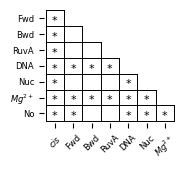

In [53]:
fig = plt.figure(figsize = (WIDTH/2, 1.5), dpi = 100)

ax = fig.add_subplot(1, 1, 1)
ax.set_yticks(np.arange(6.5,0,-1), ["Fwd", "Bwd", "RuvA", "DNA", "Nuc", "$Mg^{2+}$", "No"])
ax.set_xticks(np.arange(.5, 7), ["$cis$", "Fwd", "Bwd", "RuvA", "DNA", "Nuc", "$Mg^{2+}$"], rotation = 45)

for i in range(0, 8):
    ax.plot([i, i], [0, 8-i], 
            lw = .7, color = "black")
    ax.plot([0, 8-i], [i, i],  
            lw = .7, color = "black")

    
c = 0
for j in range(7):
    for i in range(1, 7-j):
        groupA = np.sum(interacts_with_energy[j, :, :], axis = 1)
        groupB = np.sum(interacts_with_energy[7-i, :, :], axis = 1)
        groupA = groupA[groupA > 0]
        groupB = groupB[groupB > 0]
        
        test = mannwhitneyu(groupA, groupB)
        c+=1
        if test.pvalue < 0.05/(8*7/2):
            ax.text(j + .33, i + .15, "*")
    i = 0
    groupA = np.sum(interacts_with_energy[j, :, :], axis = 1)
    groupB = doesnt_interact_energy
    groupA = groupA[groupA > 0]
    groupB = groupB[groupB > 0]
        
    c+=1
    test = mannwhitneyu(groupA, groupB)
    if test.pvalue < 0.05/(8*7/2):
            ax.text(j + .33, i + .15, "*")

ax.set_xlim(-0.1, 7.03)
ax.set_ylim(-0.1, 7.02)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


KruskalResult(statistic=58.32468864468865, pvalue=2.1624933541165454e-13)
3.3383888204288e-11
3.3519512970119317e-08
0.00011747191610492368


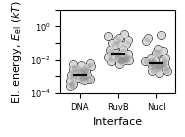

In [54]:
fig = plt.figure(figsize = (WIDTH*.44, 1.1), dpi = 100)
ax = fig.add_subplot(1, 1, 1)

# DNA
total_DNA = np.sum(interacts_with_energy[4, :, :], axis = 1)
fancy_scatter(ax, 0*np.ones(30) + np.random.rand(30)*.6, total_DNA,
              "gray", 30, .7, .3)

ax.scatter(0 + .3, np.median(total_DNA),
           color = "black", marker = "_", s = 100)
    

# Intersubunit
total_RuvB = np.sum(interacts_with_energy[1, :, :], axis = 1) + np.sum(interacts_with_energy[2, :, :], axis = 1)
fancy_scatter(ax, 1*np.ones(30) + np.random.rand(30)*.6, total_RuvB,
              "gray", 30, .7, .3)

ax.scatter(1 + .3, np.median(total_RuvB),
           color = "black", marker = "_", s = 100)


# Nucleotide
total_nuc = np.sum(interacts_with_energy[5, :, :], axis = 1)
fancy_scatter(ax, 2*np.ones(30) + np.random.rand(30)*.6, total_nuc,
              "gray", 30, .7, .3)

ax.scatter(2 + .3, np.median(total_nuc),
           color = "black", marker = "_", s = 100)

ax.set_ylabel(axis_Eel_short)
ax.set_yscale("log")
ax.set_ylim(1e-4, 1e1)
ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1], ["$10^{-4}$", "", "$10^{-2}$", "", "$10^0$", ""])

ax.set_xticks([.3, 1.3, 2.3], ["DNA", "RuvB", "Nucl"])
ax.set_xlim(-.2, 2.8)
ax.set_xlabel("Interface")

print(kruskal(*[total_DNA, total_RuvB, total_nuc])) 
test = mannwhitneyu(total_DNA, total_RuvB)
print(test.pvalue)
test = mannwhitneyu(total_DNA, total_nuc)
print(test.pvalue)
test = mannwhitneyu(total_RuvB, total_nuc)
print(test.pvalue)

plt.show()

Text(0, 0.5, '$\\langle E_{el} \\rangle$ ($kT$)')

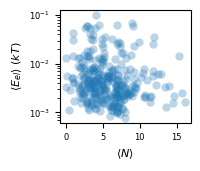

In [55]:
fig = plt.figure(figsize = (WIDTH/2, 1.5), dpi = 100)
n_inter = np.zeros(residues_energy_resh.shape)

for i in range(len(residues_idx)):
    for j in range(residues_energy_resh.shape[1]):
    
        for inter in interactions[i, j]:
            n_inter[i, j] += len(inter)

plt.yscale("log")
plt.scatter(np.mean(n_inter, axis = 1), 
            np.mean(residues_energy_resh, axis = 1),
            alpha = 0.3, lw = 0, color = "C0")

plt.xlabel("$\\langle N \\rangle$")
plt.ylabel("$\\langle E_{el} \\rangle$ ($kT$)")


In [56]:
np.corrcoef(np.mean(n_inter, axis = 1), 
            np.mean(residues_energy_resh, axis = 1))


array([[ 1.        , -0.07686883],
       [-0.07686883,  1.        ]])

# Interactions vs Mechanically active regions

In [57]:
interacts_with_names = ["Same chain", "Position +1", "Position -1", "RuvA", "DNA", "Nucleotide", "Mg2+"]
interacts_with_energy = np.zeros((7, 30, len(mech_active_reg) + 1))

for i in range(len(residues_idx)):
    reg_idx = -1
    for p in range(len(mech_active_reg)):
        if i in mech_active_reg[p]:
            reg_idx = p
    if reg_idx == -1:
        reg_idx = len(mech_active_reg)
    

    for j in range(residues_energy_resh.shape[1]):
        interaction_list = []
        
        n_inter = 0
        for inter in interactions[i, j]:
            for l in inter:
                interaction_list.append(l)
        
        n_inter = len(interaction_list)
                   
        for l in interaction_list:
            if l[0] == repeated_chain_names[j]:
                c = 0
            elif l[0] == chain_names[(j//5 + 1) % 6]:
                c = 1
            elif l[0] == chain_names[(j//5 - 1) % 6]:
                c = 2
            elif l[0] in ["G", "H"]:
                c = 3
            elif l[0] in ["U", "V"]:
                c = 4
            elif l[0] in ["I", "J", "K", "L", "M", "N"]:
                c = 5
            elif l[0] == "O":
                c = 6
            else:
                print(l[0], repeated_chain_names[j])
            interacts_with_energy[c, j, reg_idx] += residues_energy_resh[i, j]/n_inter
    

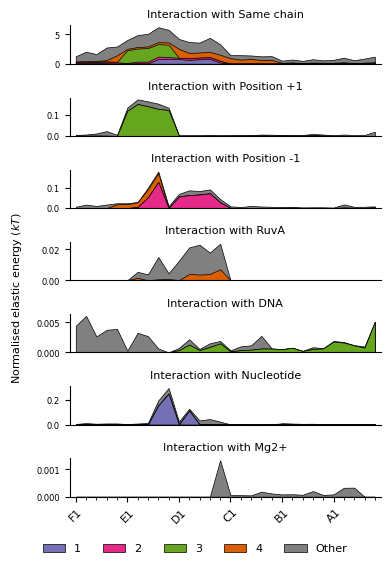

In [58]:
fig = plt.figure(figsize = (4, 6), dpi = 100)
fig.supylabel("Normalised elastic energy ($kT$)", fontsize = 8, x = 0.06, horizontalalignment = "center")

for i in range(len(interacts_with_names)):
    ax = fig.add_subplot(7, 1, i+1)
    
    prev = np.zeros(30)
    for j in range(len(mech_active_reg) + 1):
        top = np.sum(interacts_with_energy[i, :, :(j+1)], axis = 1)
        
        if j == len(mech_active_reg):
            color = "gray"
            label = "Other"
        else:
            color = mech_active_colors[j]
            label = str(j+1)
        
        ax.fill_between(range(30), top, 
                        color = color, 
                        zorder = -j,
                        lw = 0.5, 
                        edgecolor = "black",
                        label = label)
    
    #ax.text(23, .15, "Interaction\nwith " + interacts_with_names[i], fontsize = 7,
    #        horizontalalignment = "center")
    ax.set_title("Interaction with " + interacts_with_names[i])
    ax.set_xticks([])
    ax.set_xlim(-.6, 29.6)
    #ax.set_yticks([0, .2], ["", "0.2"])
    ax.set_ylim(0)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)    
    
    if i == len(interacts_with_names) - 1:
        ax.xaxis.set_minor_locator(MultipleLocator(1))
        ax.set_xticks(range(0, 30, 5), 
                      state_chain_names_short[0:30:5], 
                      fontsize = 8,rotation = 45)
        
plt.legend(fontsize = 8, loc = (-0.1, -1.6), ncol = 5)
plt.tight_layout()

# Intersubunit interface

Region 3  (74%)
Other  (25%)


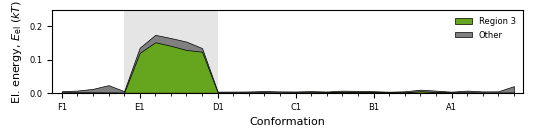

In [59]:
fig = plt.figure(figsize = (WIDTH*1.8, 1.1), dpi = 100)

for i in [1]:
    ax = fig.add_subplot(1, 1, 1)
    
    prev = np.zeros(30)
    for j in [2, 4]:
        top = np.sum(interacts_with_energy[i, :, :(j+1)], axis = 1)
        
        if j == len(mech_active_reg):
            color = "gray"
            label = "Other"
        else:
            color = mech_active_colors[j]
            label = "Region " + str(j+1)
            
        total = np.sum(interacts_with_energy[i, :, j]) / np.sum(interacts_with_energy[i])
        total = " (" + str(int(np.round(total, 2) * 100)) + "%)"
        
        #label = label + total
        print(label, total)
        
        ax.fill_between(range(30), top, 
                        color = color, 
                        zorder = -j,
                        lw = 0.5, 
                        edgecolor = "black",
                        label = label)
    
ax.set_xticks([])
ax.set_xlim(-.6, 29.6)
ax.set_ylim(0, .25)
ax.set_yticks([0, 0.1, .2])

ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_xticks(range(0, 30, 5), 
              state_chain_names_short[0:30:5])
ax.set_ylabel(axis_Eel_short)
ax.set_xlabel("Conformation")
ax.fill_between(range(4, 11), 0, 1, color = "black", alpha = .1, lw = 0, zorder = -10)

ax.legend()
plt.show()

Region 2  (54%)
Region 4  (17%)
Other  (28%)


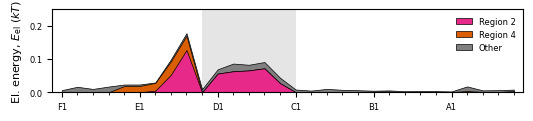

In [60]:
fig = plt.figure(figsize = (WIDTH*1.8, 1.1), dpi = 100)

for i in [2]:
    ax = fig.add_subplot(1, 1, 1)
    
    prev = np.zeros(30)
    for j in [1, 3, 4]:
        top = np.sum(interacts_with_energy[i, :, :(j+1)], axis = 1)
        
        if j == len(mech_active_reg):
            color = "gray"
            label = "Other"
        else:
            color = mech_active_colors[j]
            label = "Region " + str(j+1)
        
        total = np.sum(interacts_with_energy[i, :, j]) / np.sum(interacts_with_energy[i])
        total = " (" + str(int(np.round(total, 2) * 100)) + "%)"
        
        #label = label + total
        print(label, total)
        
        ax.fill_between(range(30), top, 
                        color = color, 
                        zorder = -j,
                        lw = 0.5, 
                        edgecolor = "black",
                        label = label)
    
ax.set_xticks([])
ax.set_xlim(-.6, 29.6)
ax.set_ylim(0, .25)
ax.set_yticks([0, 0.1, .2])

ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_xticks(range(0, 30, 5), 
              state_chain_names_short[0:30:5])

ax.set_ylabel(axis_Eel_short)    
ax.fill_between(range(9, 16), 0, 1, color = "black", alpha = .1, lw = 0, zorder = -10)
    
ax.legend()
plt.show()

# Nucleotide binding pocket 

In [61]:
nbp_core = [29, 62, 64, 65, 66, 67, 181]
nbp_core = [residues_idx.index(i) for i in nbp_core]

reg_1 = mech_active_reg[0]
others = [i for i in range(len(residues_idx)) if i not in nbp_core + reg_1]

interacts_with_names = ["Same chain", "Position +1", "Position -1", "RuvA", "DNA", "Nucleotide", "Mg2+"]
interacts_with_energy = np.zeros((7, 30, 3))

for i in range(len(residues_idx)):
    
    reg_idx = -1
    for r, reg in zip(range(3), [reg_1, nbp_core, others]):
        if i in reg:
            reg_idx = r
        
    for j in range(residues_energy_resh.shape[1]):
        interaction_list = []

        n_inter = 0
        for inter in interactions[i, j]:
            for l in inter:
                interaction_list.append(l)

        n_inter = len(interaction_list)

        for l in interaction_list:
            if l[0] == repeated_chain_names[j]:
                c = 0
            elif l[0] == chain_names[(j//5 + 1) % 6]:
                c = 1
            elif l[0] == chain_names[(j//5 - 1) % 6]:
                c = 2
            elif l[0] in ["G", "H"]:
                c = 3
            elif l[0] in ["U", "V"]:
                c = 4
            elif l[0] in ["I", "J", "K", "L", "M", "N"]:
                c = 5
            elif l[0] == "O":
                c = 6
            else:
                print(l[0], repeated_chain_names[j])
            interacts_with_energy[c, j, reg_idx] += residues_energy_resh[i, j]/n_inter


Gate (62%)
Core (32%)
Other (6%)


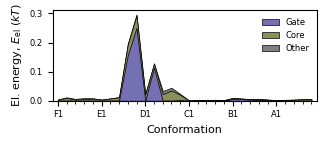

In [62]:
fig = plt.figure(figsize = (WIDTH*1.01, 1.2), dpi = 100)


for i in [5]:
    ax = fig.add_subplot(1, 1, 1)
    
    prev = np.zeros(30)
    for j in range(3):
        top = np.sum(interacts_with_energy[i, :, :(j+1)], axis = 1)
        
        if j == 0:
            color = mech_active_colors[0]
            label = "Gate"
        elif j == 1:
            color = "#8b8f59"
            label = "Core"
        else:
            color = "gray"
            label = "Other"
            
        total = np.sum(interacts_with_energy[i, :, j]) / np.sum(interacts_with_energy[i])
        total = " (" + str(int(np.round(total, 2) * 100)) + "%)"
        
        #label = label + total
        print(label + total)
        
        ax.fill_between(range(30), top, 
                        color = color, 
                        zorder = -j,
                        lw = 0.5, 
                        edgecolor = "black",
                        label = label)
    
    ax.set_xticks([])
    ax.set_xlim(-.6, 29.6)
    ax.set_ylim(0)
    
    
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.set_xticks(range(0, 30, 5), 
                  state_chain_names_short[0:30:5])

ax.set_ylabel(axis_Eel_short)
ax.set_xlabel("Conformation")
        
plt.legend()
plt.show()

# Energy in sensor 1 motif (Spring-like motif)

In [63]:
spring_idx = np.array(mech_active_reg[1][:3])
spring_idx

array([137, 138, 139])

In [64]:
helix_conf = np.concatenate([np.array([0, 2]), np.arange(15, 30)])
loop_conf = np.concatenate([np.array([1]), np.arange(3, 15)])

print([state_chain_names[i] for i in helix_conf])
print([state_chain_names[i] for i in loop_conf])

['F1', 'F3', 'C1', 'C2', 'C3', 'C4', 'C5', 'B1', 'B2', 'B3', 'B4', 'B5', 'A1', 'A2', 'A3', 'A4', 'A5']
['F2', 'F4', 'F5', 'E1', 'E2', 'E3', 'E4', 'E5', 'D1', 'D2', 'D3', 'D4', 'D5']


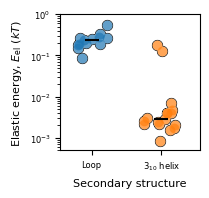

MannwhitneyuResult(statistic=217.0, pvalue=9.152437201525345e-06)


0.2303332895586305

In [66]:
fig = plt.figure(figsize = (1.8, 1.8), dpi = 100)
ax = fig.add_subplot(1,1,1)


fancy_scatter(ax,
              np.zeros(len(loop_conf)) + np.random.rand(len(loop_conf))*.5, 
              np.sum(residues_energy_resh[spring_idx][:, loop_conf], axis = 0),
              "C0", 50, 1, .7)

ax.scatter(.25, 
           np.median(np.sum(residues_energy_resh[spring_idx][:, loop_conf], axis = 0)),
           color = "black", marker = "_", s = 100)

fancy_scatter(ax,
              np.ones(len(helix_conf)) + np.random.rand(len(helix_conf))*.5, 
              np.sum(residues_energy_resh[spring_idx][:, helix_conf], axis = 0),
              "C1", 50, 1, .7)

ax.scatter(1.25, 
           np.median(np.sum(residues_energy_resh[spring_idx][:, helix_conf], axis = 0)),
           color = "black", marker = "_", s = 100)


ax.set_xlim(-.2, 1.8)
ax.set_xticks([.25, 1.25], ["Loop", "$3_{10}$ helix"])
ax.set_xlabel("Secondary structure")

ax.set_yscale("log")
ax.set_ylim(5e-4, 1e0)
ax.set_yticks([1, .1, .01, .001])
ax.set_ylabel(axis_Eel)

plt.show()

print(mannwhitneyu(np.sum(residues_energy_resh[spring_idx][:, loop_conf], axis = 0), 
                   np.sum(residues_energy_resh[spring_idx][:, helix_conf], axis = 0)))

np.median(np.sum(residues_energy_resh[spring_idx][:, loop_conf], axis = 0)) - np.median(np.sum(residues_energy_resh[spring_idx][:, helix_conf], axis = 0))

# Correlation between conservation and strain

KruskalResult(statistic=6.2495989473727604, pvalue=0.10007840902701873)


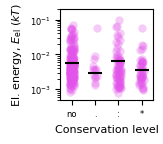

In [67]:
fig = plt.figure(figsize = (1.2,1.2), dpi = 100)
ax1 = fig.add_subplot(1,1,1)

cons = np.zeros(len(residues_idx))
for i in range(len(residues_idx)):
    if conserved[i] == " ":
        cons[i] = 0
        
    elif conserved[i] == ".":
        cons[i] = 1
        
    elif conserved[i] == ":":
        cons[i] = 2
        
    elif conserved[i] == "*":
        cons[i] = 3

norm = residues_energy_resh
ax1.set_yscale("log")
ax1.scatter(cons + (np.random.rand(len(cons))-.5)*.2, 
            np.mean(norm, axis = 1), alpha = 0.3, lw = 0,
            color = "#e355ea")

for i in range(4):
    ax1.scatter(i, np.median(np.mean(norm[cons == i], axis = 0)), 
                color = "black", marker = "_", s = 100)

ax1.set_ylabel(axis_Eel_short)
ax1.set_xlabel("Conservation level")
ax1.set_xticks(range(4), ["no", ".", ":", "*"])
ax1.set_ylim(5e-4, 2e-1)
ax1.set_xlim(-.5, 3.5)


# Conduct the one-way ANOVA
print(kruskal(*[np.mean(norm[cons == i], axis = 1) for i in range(4)])) 


plt.show()


In [68]:
motifs_ranges = [range(20, 33),
                 range(38, 46),
                 range(54, 77),
                 range(85, 99),
                 range(101, 116),
                 range(121, 137),
                 range(151, 165),
                 range(167, 182),
                 range(209, 224),
                 range(293, 319)]

motifs = [[i for i in range(len(residues_idx)) if residues_idx[i] in m] for m in motifs_ranges]
non_motifs = [i for i in range(len(residues_idx)) if i not in np.concatenate(motifs)]

KruskalResult(statistic=74.73084327988556, pvalue=5.367623345092752e-12)
1 MannwhitneyuResult(statistic=1160.0, pvalue=0.2389911718258958) 

2 MannwhitneyuResult(statistic=135.0, pvalue=4.864544357845999e-05) 

3 MannwhitneyuResult(statistic=1212.0, pvalue=0.024198018196315434) 

4 MannwhitneyuResult(statistic=1551.0, pvalue=0.0026495844556521705) 

5 MannwhitneyuResult(statistic=935.0, pvalue=0.2991766737899919) 

6 MannwhitneyuResult(statistic=1950.0, pvalue=3.02934933947611e-05) 

7 MannwhitneyuResult(statistic=1004.0, pvalue=0.8196309636741821) 

8 MannwhitneyuResult(statistic=805.0, pvalue=0.07511320713496475) 

9 MannwhitneyuResult(statistic=337.0, pvalue=8.609802853550944e-06) 

10 MannwhitneyuResult(statistic=1748.0, pvalue=0.429061586879968) 



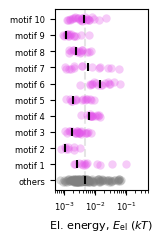

In [69]:
fig = plt.figure(figsize = (1.2, 2.4), dpi = 100)
ax1 = fig.add_subplot(1,1,1)


norm = residues_energy_resh
ax1.set_xscale("log")

for i in range(len(motifs)):
    ax1.scatter(y = i + (np.random.rand(len(motifs[i]))-.5)*.2, 
                x = np.mean(norm[motifs[i]], axis = 1), alpha = 0.3, lw = 0,
                color = "#e355ea")

    ax1.scatter(y = i, x = np.median(np.mean(norm[motifs[i]], axis = 0)), 
                color = "black", marker = "|", s = 30)

ax1.scatter(y = -1 + (np.random.rand(len(non_motifs))-.5)*.2, 
            x = np.mean(norm[non_motifs], axis = 1), alpha = 0.3, lw = 0,
            color = "gray")
ax1.scatter(y = -1, x = np.median(np.mean(norm[non_motifs], axis = 0)), 
            color = "black", marker = "|", s = 30)
ax1.axvline(x = np.median(np.mean(norm[non_motifs], axis = 0)), 
            color = "black", alpha = 0.1, zorder = -1, linestyle = "dashed")

    
    
ax1.set_xlabel(axis_Eel_short)
ax1.set_yticks(range(-1, 10), ["others"] + ["motif " + str(i) for i in range(1, 11)])
ax1.set_xlim(5e-4, 5e-1)
#ax1.set_xlim(-.5, 3.5)

# Conduct the one-way ANOVA
print(kruskal(*[np.mean(norm[motifs[i]], axis = 1) for i in range(10)] + [np.mean(norm[non_motifs], axis = 1)]))

for i in range(len(motifs)):
    print(i+1, mannwhitneyu(np.mean(norm[motifs[i]], axis = 1), 
                            np.mean(norm[non_motifs], axis = 1)),
          
          "\n")

plt.show()


# Correlation between mutagenesis and strain

KruskalResult(statistic=7.3926796101835635, pvalue=0.06038104820965724)


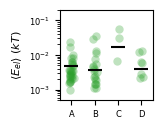

In [70]:
fig = plt.figure(figsize = (1.2,1.2), dpi = 100)
ax1 = fig.add_subplot(1,1,1)
ax1.set_yscale("log")

norm = residues_energy_resh
mut = np.ones(len(residues_idx)) * 10
for i in range(len(residues_idx)): 
    if mutated[i] == "A":
        mut[i] = 0
        
    elif mutated[i] == "B":
        mut[i] = 1
        
    elif mutated[i] == "C":
        mut[i] = 2
        
    elif mutated[i] == "D":
        mut[i] = 3

mut[mut == 10] = np.nan
ax1.scatter(mut + (np.random.rand(len(mut))-.5)*.2, 
            np.mean(norm, axis = 1), alpha = 0.3, lw = 0,
            color = "#2ca02c")


for i in range(4):
    ax1.scatter(i, np.median(np.mean(norm[mut == i], axis = 0)),
                color = "black", marker = "_", s = 100)


ax1.set_xticks(range(4), ["A", "B", "C", "D"])
ax1.set_ylabel("$\\langle E_{el} \\rangle$ ($kT$)")
ax1.set_ylim(5e-4, 2e-1)
ax1.set_xlim(-.5, 3.5)

print(kruskal(*[np.mean(norm[mut == i], axis = 1) for i in range(4)])) 


plt.show()


# Get position of the residues of aligned chains

In [71]:
# Input
s_names_single = ['s1t2', 's2t2', 's3t2', 's4t2', 's5t2']

# Compute
s_pps_single = []
for chain in chain_names:
    for name in s_names_single:
        structure = load.single_structure(name, chain_ids = "X", relabel = {chain: "X"})        
        s_pps_single.append(structure)

        
uni_ids = [None] * 1
indexes = []
labels_al = []
labels_al_at = []

# Compute
my_ref_seqs = seq.generate_reference(s_pps_single[18], uni_ids)

for i in range(len(s_pps_single)):
    labels_al.append(seq.aligned_dict(s_pps_single[i], seq.align(s_pps_single[i], my_ref_seqs)))
    labels_al_at.append(seq.aligned_dict_all_atoms(s_pps_single[i], seq.align(s_pps_single[i], my_ref_seqs)))

com_res = seq.common_multiple([labels_al[i] for i in range(30)])
com_at = seq.common_multiple([labels_al_at[i] for i in range(30)])

for i in range(1,len(s_pps_single)):
    spatial.align_structures(s_pps_single[0], s_pps_single[i], ["X"], com_res, 
                             labels_al[0], labels_al[i], "atoms", ["<Atom OXT>"])
    
xyz_single = []
labels_single = []

for i in range(len(s_pps_single)):
    t1, t2 = load.coordinates(s_pps_single[i], com_res, labels_al[i])
    xyz_single.append(t1)
    labels_single.append(t2)

# Energy profile per Mechanically active region

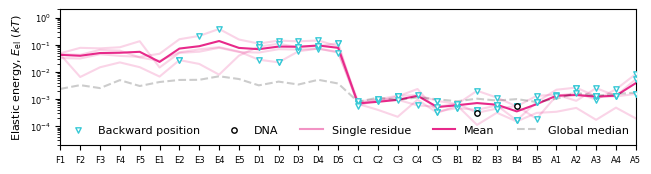

In [72]:
%matplotlib inline
fig = plt.figure(figsize=(WIDTH*2.2, 1.8), dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.set_ylabel(axis_Eel)
ax.set_yscale("log")

I = 1

ax.plot(residues_energy_resh[mech_active_reg[I]].T, alpha = 0.2, color = mech_active_colors[I])
ax.plot(np.mean(residues_energy_resh[mech_active_reg[I]].T, axis = 1), color = mech_active_colors[I])
ax.plot(residues_energy_med, color = "black", linestyle = "dashed", alpha = 0.2)

for k in range(3):
    for i in mech_active_reg[I]:
        for j in range(residues_energy_resh.shape[1]):
            interaction_list = interactions[i, j, k]
            for l in interaction_list:
                if l[0] == repeated_chain_names[j]:
                    next
                elif l[0] == chain_names[(j//5 - 1) % 6]:
                    ax.scatter(j, residues_energy_resh[i, j], edgecolor = "#37c9d6ff", 
                               color = "white", s = 15, marker = "v", zorder = 3)
                elif l[0] in ["U", "V"]:
                    ax.scatter(j, residues_energy_resh[i, j], edgecolor = "black", 
                               color = "white", s = 15, marker = "o", zorder = 3)
                else:
                    print(l[0])
                    
ax.scatter(np.nan, np.nan, label = "Backward position", s = 15, marker = "v", 
           color = "white", edgecolor = "#37c9d6ff")
ax.scatter(np.nan, np.nan, label = "DNA", s = 15, marker = "o", 
           color = "white", edgecolor = "black")
ax.plot(np.nan, alpha = 0.5, color = mech_active_colors[I], label = "Single residue")
ax.plot(np.nan, alpha = 1, color = mech_active_colors[I], label = "Mean")
ax.plot(np.nan, alpha = 0.2, color = "black", linestyle = "dashed", label = "Global median")
ax.legend(ncol = 5, fontsize = 8, loc = "lower center")


x = range(len(state_chain_names))
ax.set_xticks(x)
ax.set_xticklabels(state_chain_names)
ax.set_xlim(0, len(x)-1)
ax.set_ylim(2e-5, 2)

plt.show()

<IPython.core.display.Javascript object>


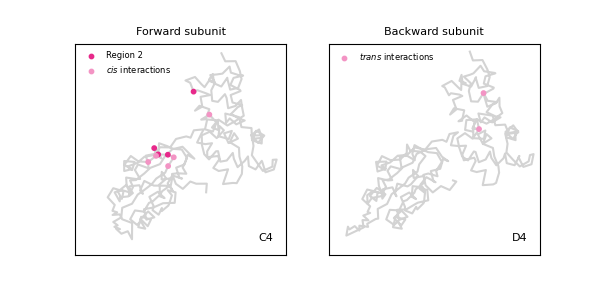

In [74]:
%matplotlib notebook

fig = plt.figure(figsize = (6, 3), dpi = 100)

I = 1
interaction_matrix = np.zeros((residues_energy_resh.shape[0],
                               residues_energy_resh.shape[1],
                               3), dtype = int)

for k in range(3):
    for i in mech_active_reg[I]:
        for j in range(residues_energy_resh.shape[1]):
            interaction_list = interactions[i, j, k]
            for l in interaction_list:
                if int(l[2]) in residues_idx:
                    if l[0] == repeated_chain_names[j]:         # same chain
                        interaction_matrix[residues_idx.index(int(l[2])), j, 1] = 1
                    
                    elif l[0] == chain_names[(j//5 - 1) % 6]:   # chain +1
                        interaction_matrix[residues_idx.index(int(l[2])), j, 0] = 1
                    
                    elif l[0] == chain_names[(j//5 + 1) % 6]:   # chain -1
                        interaction_matrix[residues_idx.index(int(l[2])), j, 2] = 1

lines_list = []
scatter_list = []
text_list = []

for i in [0, 1]:
    darker_color = np.ones(4)
    darker_color[:3] = colors.hex2color(mech_active_colors[I])
    lighter_color = (darker_color + np.ones(4))/2
    
    if i == 1:
        ax = fig.add_subplot(1,2,1)
        ax.set_title("Forward subunit")
        ax.scatter(np.nan, np.nan, s = 10, color = darker_color, label = "Region " + str(I+1))
        ax.scatter(np.nan, np.nan, s = 10, color = lighter_color, label = "$cis$ interactions")
        
    elif i == 0:
        ax = fig.add_subplot(1,2,2)
        ax.set_title("Backward subunit")
        ax.scatter(np.nan, np.nan, s = 10, color = lighter_color, label = "$trans$ interactions")
              
    ys, zs = xyz_single[0][:,1], xyz_single[0][:,2]

    lines, = ax.plot(ys, zs, color = "lightgray", zorder = -1)
    lines_list += [lines]
    
    text = ax.text(225, 165, "")
    text_list += [text]
    
    scatter_colors = np.array([lighter_color for i in range(len(residues_idx))])
    scatter_colors[mech_active_reg[I]] = darker_color
    scatter = ax.scatter(ys, zs, s = 10, color = scatter_colors, alpha = 0)
    scatter_list += [scatter]
    
    ax.legend(fontsize = 6, frameon = False, loc = "upper left")    
    
    ax.axis("scaled")
    ax.set_xlim(160, 235)
    ax.set_ylim(160, 235)
    ax.set_xticks([])
    ax.set_yticks([])

def update(frame):
    for lines, scatter, text, i in zip(lines_list, scatter_list, text_list, [0, 1]):
        offset = (i-1)*5
        f = (frame + offset) % 30
        coords = xyz_single[f]
        ys, zs = coords[:, 1], coords[:, 2]

        lines.set_xdata(ys)
        lines.set_ydata(zs)

        scatter.set_alpha(interaction_matrix[:, frame, i])
        scatter.set_offsets(np.c_[ys, zs])

        text.set_text(state_chain_names[f])

    return lines_list, scatter_list, text_list

ani = FuncAnimation(fig, update, frames = 30, interval = 300, repeat = True)
writervideo = animation.PillowWriter(fps = 2)
ani.save("movie/Region_" +str(I+1)+ ".gif", writer = writervideo)
plt.show()

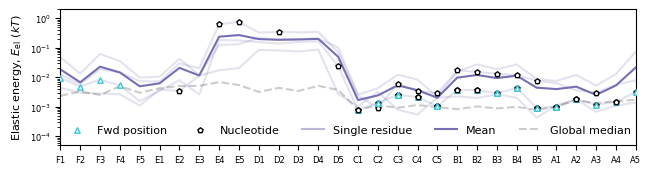

In [76]:
%matplotlib inline

fig = plt.figure(figsize=(WIDTH*2.2, 1.8), dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.set_ylabel(axis_Eel)
ax.set_yscale("log")

I = 0

ax.plot(residues_energy_resh[mech_active_reg[I]].T, alpha = 0.2, color = mech_active_colors[I])
ax.plot(np.mean(residues_energy_resh[mech_active_reg[I]].T, axis = 1), color = mech_active_colors[I])
ax.plot(residues_energy_med, color = "black", linestyle = "dashed", alpha = 0.2)

for k in range(3):
    for i in mech_active_reg[I]:
        for j in range(residues_energy_resh.shape[1]):
            interaction_list = interactions[i, j, k]
            for l in interaction_list:
                if l[0] == chain_names[(j//5 + 1) % 6]:
                    ax.scatter(j, residues_energy_resh[i, j], edgecolor = "#37c9d6ff", 
                               color = "white", s = 15, marker = "^", zorder = 3)
                    
                elif l[0] in ["I", "J", "K", "L", "M", "N"]:
                    ax.scatter(j, residues_energy_resh[i, j], edgecolor = "black", 
                               color = "white", s = 15, marker = "p", zorder = 3)
                    
ax.scatter(np.nan, np.nan, label = "Fwd position", s = 15, marker = "^", edgecolor = "#37c9d6ff", color = "white")
ax.scatter(np.nan, np.nan, label = "Nucleotide", s = 15, marker = "p", edgecolor = "black", color = "white")
ax.plot(np.nan, alpha = 0.5, color = mech_active_colors[I], label = "Single residue")
ax.plot(np.nan, alpha = 1, color = mech_active_colors[I], label = "Mean")
ax.plot(np.nan, alpha = 0.2, color = "black", linestyle = "dashed", label = "Global median")
ax.legend(frameon = False, fontsize = 8, loc = "lower center", ncol = 5)
                
x = range(len(state_chain_names))
ax.set_xticks(x)
ax.set_xticklabels(state_chain_names)
ax.set_xlim(0, len(x)-1)
ax.set_ylim(5e-5, 2)
plt.show()

<IPython.core.display.Javascript object>


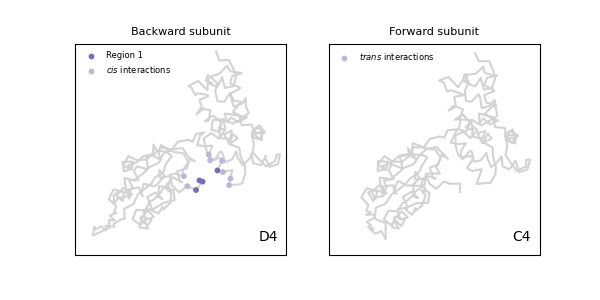

In [77]:
%matplotlib notebook

fig = plt.figure(figsize = (6, 3), dpi = 100)

I = 0
interaction_matrix = np.zeros((residues_energy_resh.shape[0],
                               residues_energy_resh.shape[1],
                               3), dtype = int)

for k in range(3):
    for i in mech_active_reg[I]:
        for j in range(residues_energy_resh.shape[1]):
            interaction_list = interactions[i, j, k]
            for l in interaction_list:
                if int(l[2]) in residues_idx:
                    if l[0] == repeated_chain_names[j]:         # same chain
                        interaction_matrix[residues_idx.index(int(l[2])), j, 1] = 1
                    
                    elif l[0] == chain_names[(j//5 - 1) % 6]:   # chain +1
                        interaction_matrix[residues_idx.index(int(l[2])), j, 0] = 1
                    
                    elif l[0] == chain_names[(j//5 + 1) % 6]:   # chain -1
                        interaction_matrix[residues_idx.index(int(l[2])), j, 2] = 1

lines_list = []
scatter_list = []
text_list = []

for i in [1,2]:
    darker_color = np.ones(4)
    darker_color[:3] = colors.hex2color(mech_active_colors[I])
    lighter_color = (darker_color + np.ones(4))/2
    
    if i == 1:
        ax = fig.add_subplot(1,2,1)
        ax.set_title("Backward subunit")
        ax.scatter(np.nan, np.nan, s = 10, color = darker_color, label = "Region " + str(I+1))
        ax.scatter(np.nan, np.nan, s = 10, color = lighter_color, label = "$cis$ interactions")
            
    elif i == 2:
        ax = fig.add_subplot(1,2,2)
        ax.set_title("Forward subunit")
        ax.scatter(np.nan, np.nan, s = 10, color = lighter_color, label = "$trans$ interactions")
          
    ys, zs = xyz_single[0][:,1], xyz_single[0][:,2]

    lines, = ax.plot(ys, zs, color = "lightgray", zorder = -1)
    lines_list += [lines]
    
    text = ax.text(225, 165, "")
    text_list += [text]
    
    scatter_colors = np.array([lighter_color for i in range(len(residues_idx))])
    scatter_colors[mech_active_reg[I]] = darker_color
    scatter = ax.scatter(ys, zs, s = 10, color = scatter_colors, alpha = 0)
    scatter_list += [scatter]
    
    ax.legend(fontsize = 6, frameon = False, loc = "upper left")    
    
    ax.axis("scaled")
    ax.set_xlim(160, 235)
    ax.set_ylim(160, 235)
    ax.set_xticks([])
    ax.set_yticks([])

def update(frame):
    for lines, scatter, text, i in zip(lines_list, scatter_list, text_list, [1,2]):
        offset = (i-1)*5
        f = (frame + offset) % 30
        coords = xyz_single[f]
        ys, zs = coords[:, 1], coords[:, 2]

        lines.set_xdata(ys)
        lines.set_ydata(zs)

        scatter.set_alpha(interaction_matrix[:, frame, i])
        scatter.set_offsets(np.c_[ys, zs])

        text.set_text(state_chain_names[f])

    return lines_list, scatter_list, text_list

ani = FuncAnimation(fig, update, frames = 30, interval = 300, repeat = True)
writervideo = animation.PillowWriter(fps = 2)
ani.save("movie/Region_" +str(I+1)+ ".gif", writer = writervideo)
plt.show()

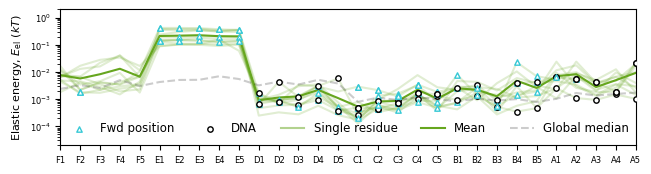

In [79]:
%matplotlib inline
fig = plt.figure(figsize=(WIDTH*2.2, 1.8), dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.set_ylabel(axis_Eel)
ax.set_yscale("log")

I = 2

ax.plot(residues_energy_resh[mech_active_reg[I]].T, alpha = 0.2, color = mech_active_colors[I])
ax.plot(np.mean(residues_energy_resh[mech_active_reg[I]].T, axis = 1), color = mech_active_colors[I])
ax.plot(residues_energy_med, color = "black", linestyle = "dashed", alpha = 0.2)

for k in range(3):
    for i in mech_active_reg[I]:
        for j in range(residues_energy_resh.shape[1]):
            interaction_list = interactions[i, j, k]
            for l in interaction_list:
                if l[0] == repeated_chain_names[j]:
                    next
                elif l[0] == chain_names[(j//5 + 1) % 6]:
                    ax.scatter(j, residues_energy_resh[i, j], edgecolor = "#37c9d6ff", 
                               color = "white", s = 15, marker = "^", zorder = 3)                    
                elif l[0] in ["U", "V"]:
                    ax.scatter(j, residues_energy_resh[i, j], edgecolor = "black", 
                               color = "white", s = 15, marker = "o", zorder = 3)
                else:
                    print(l[0])
                    

ax.scatter(np.nan, np.nan, label = "Fwd position", s = 15, marker = "^", 
           color = "white", edgecolor = "#37c9d6ff")
ax.scatter(np.nan, np.nan, label = "DNA", s = 15, marker = "o", 
           color = "white", edgecolor = "black")
ax.plot(np.nan, alpha = 0.5, color = mech_active_colors[I], label = "Single residue")
ax.plot(np.nan, alpha = 1, color = mech_active_colors[I], label = "Mean")
ax.plot(np.nan, alpha = 0.2, color = "black", linestyle = "dashed", label = "Global median")
ax.legend(ncol = 5, fontsize = 8.5, loc = "lower center")

x = range(len(state_chain_names))
ax.set_xticks(x)
ax.set_xticklabels(state_chain_names)
ax.set_xlim(0, len(x)-1)
ax.set_ylim(2e-5, 2)
plt.show()

<IPython.core.display.Javascript object>


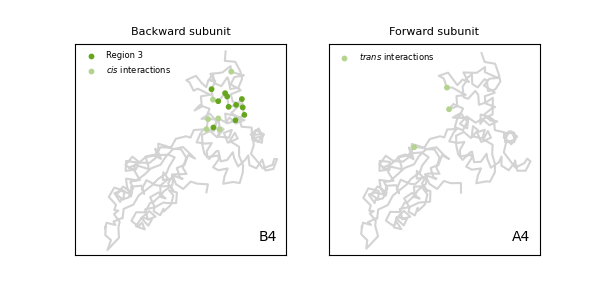

In [80]:
%matplotlib notebook

fig = plt.figure(figsize = (6, 3), dpi = 100)

I = 2
interaction_matrix = np.zeros((residues_energy_resh.shape[0],
                               residues_energy_resh.shape[1],
                               3), dtype = int)

for k in range(3):
    for i in mech_active_reg[I]:
        for j in range(residues_energy_resh.shape[1]):
            interaction_list = interactions[i, j, k]
            for l in interaction_list:
                if int(l[2]) in residues_idx:
                    if l[0] == repeated_chain_names[j]:         # same chain
                        interaction_matrix[residues_idx.index(int(l[2])), j, 1] = 1
                    
                    elif l[0] == chain_names[(j//5 + 1) % 6]:   # chain +1
                        interaction_matrix[residues_idx.index(int(l[2])), j, 2] = 1

lines_list = []
scatter_list = []
text_list = []

for i in [1, 2]:
    darker_color = np.ones(4)
    darker_color[:3] = colors.hex2color(mech_active_colors[I])
    lighter_color = (darker_color + np.ones(4))/2
    
    if i == 1:
        ax = fig.add_subplot(1,2,1)
        ax.set_title("Backward subunit")
        ax.scatter(np.nan, np.nan, s = 10, color = darker_color, label = "Region " + str(I+1))
        ax.scatter(np.nan, np.nan, s = 10, color = lighter_color, label = "$cis$ interactions")
                
    elif i == 2:
        ax = fig.add_subplot(1,2,2)
        ax.set_title("Forward subunit")
        ax.scatter(np.nan, np.nan, s = 10, color = lighter_color, label = "$trans$ interactions")
          
    ys, zs = xyz_single[0][:,1], xyz_single[0][:,2]

    lines, = ax.plot(ys, zs, color = "lightgray", zorder = -1)
    lines_list += [lines]
    
    text = ax.text(225, 165, "")
    text_list += [text]
    
    scatter_colors = np.array([lighter_color for i in range(len(residues_idx))])
    scatter_colors[mech_active_reg[I]] = darker_color
    scatter = ax.scatter(ys, zs, s = 10, color = scatter_colors, alpha = 0)
    scatter_list += [scatter]
    
    ax.legend(fontsize = 6, frameon = False, loc = "upper left")    
    
    ax.axis("scaled")
    ax.set_xlim(160, 235)
    ax.set_ylim(160, 235)
    ax.set_xticks([])
    ax.set_yticks([])

def update(frame):
    for lines, scatter, text, i in zip(lines_list, scatter_list, text_list, [1, 2]):
        offset = (i-1)*5
        f = (frame + offset) % 30
        coords = xyz_single[f]
        ys, zs = coords[:, 1], coords[:, 2]

        lines.set_xdata(ys)
        lines.set_ydata(zs)

        scatter.set_alpha(interaction_matrix[:, frame, i])
        scatter.set_offsets(np.c_[ys, zs])

        text.set_text(state_chain_names[f])

    return lines_list, scatter_list, text_list

ani = FuncAnimation(fig, update, frames = 30, interval = 300, repeat = True)
writervideo = animation.PillowWriter(fps = 2)
ani.save("movie/Region_" +str(I+1)+ ".gif", writer = writervideo)
plt.show()

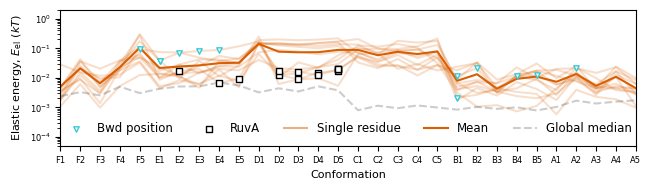

In [82]:
%matplotlib inline

fig = plt.figure(figsize=(WIDTH*2.2, 1.8), dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.set_ylabel(axis_Eel)
ax.set_yscale("log")

I = 3

ax.plot(residues_energy_resh[mech_active_reg[I]].T, alpha = 0.2, color = mech_active_colors[I])
ax.plot(np.mean(residues_energy_resh[mech_active_reg[I]].T, axis = 1), color = mech_active_colors[I])
ax.plot(residues_energy_med, color = "black", linestyle = "dashed", alpha = 0.2)

for k in range(3):
    for i in mech_active_reg[I]:
        for j in range(residues_energy_resh.shape[1]):
            interaction_list = interactions[i, j, k]
            for l in interaction_list:
                if l[0] == repeated_chain_names[j]:
                    next
                elif l[0] == chain_names[(j//5 - 1) % 6]:
                    ax.scatter(j, residues_energy_resh[i, j], edgecolor = "#37c9d6ff", 
                               color = "white", s = 15, marker = "v", zorder = 3)
                    
                elif l[0] in ["G", "H"]:
                    ax.scatter(j, residues_energy_resh[i, j], edgecolor = "black", 
                               color = "white", s = 15, marker = "s", zorder = 3)


ax.scatter(np.nan, np.nan, label = "Bwd position", s = 15, marker = "v", 
           color = "white", edgecolor = "#37c9d6ff")
ax.scatter(np.nan, np.nan, label = "RuvA", s = 15, marker = "s", 
           color = "white", edgecolor = "black")
ax.plot(np.nan, alpha = 0.5, color = mech_active_colors[I], label = "Single residue")
ax.plot(np.nan, alpha = 1, color = mech_active_colors[I], label = "Mean")
ax.plot(np.nan, alpha = 0.2, color = "black", linestyle = "dashed", label = "Global median")
ax.legend(ncol = 5, fontsize = 8.5, loc = "lower center")

x = range(len(state_chain_names))
ax.set_xticks(x)
ax.set_xticklabels(state_chain_names)
ax.set_xlim(0, len(x)-1)
ax.set_ylim(5e-5, 2)
ax.set_xlabel("Conformation")
plt.show()

<IPython.core.display.Javascript object>


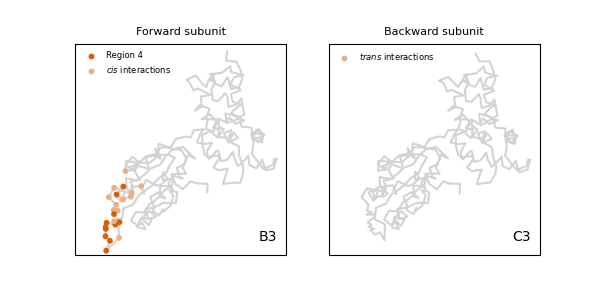

In [84]:
%matplotlib notebook

fig = plt.figure(figsize = (6, 3), dpi = 100)

I = 3
interaction_matrix = np.zeros((residues_energy_resh.shape[0],
                               residues_energy_resh.shape[1],
                               3), dtype = int)

for k in range(3):
    for i in mech_active_reg[I]:
        for j in range(residues_energy_resh.shape[1]):
            interaction_list = interactions[i, j, k]
            for l in interaction_list:
                if int(l[2]) in residues_idx:
                    if l[0] == repeated_chain_names[j]:         # same chain
                        interaction_matrix[residues_idx.index(int(l[2])), j, 1] = 1
                    
                    elif l[0] == chain_names[(j//5 - 1) % 6]:   # chain +1
                        interaction_matrix[residues_idx.index(int(l[2])), j, 0] = 1
                    
                    elif l[0] == chain_names[(j//5 + 1) % 6]:   # chain -1
                        interaction_matrix[residues_idx.index(int(l[2])), j, 2] = 1

lines_list = []
scatter_list = []
text_list = []

for i in [0, 1]:
    darker_color = np.ones(4)
    darker_color[:3] = colors.hex2color(mech_active_colors[I])
    lighter_color = (darker_color + np.ones(4))/2
    
    if i == 1:
        ax = fig.add_subplot(1,2,1)
        ax.set_title("Forward subunit")
        ax.scatter(np.nan, np.nan, s = 10, color = darker_color, label = "Region " + str(I+1))
        ax.scatter(np.nan, np.nan, s = 10, color = lighter_color, label = "$cis$ interactions")
        
    elif i == 0:
        ax = fig.add_subplot(1,2,2)
        ax.set_title("Backward subunit")
        ax.scatter(np.nan, np.nan, s = 10, color = lighter_color, label = "$trans$ interactions")
              
    ys, zs = xyz_single[0][:,1], xyz_single[0][:,2]

    lines, = ax.plot(ys, zs, color = "lightgray", zorder = -1)
    lines_list += [lines]
    
    text = ax.text(225, 165, "")
    text_list += [text]
    
    scatter_colors = np.array([lighter_color for i in range(len(residues_idx))])
    scatter_colors[mech_active_reg[I]] = darker_color
    scatter = ax.scatter(ys, zs, s = 10, color = scatter_colors, alpha = 0)
    scatter_list += [scatter]
    
    ax.legend(fontsize = 6, frameon = False, loc = "upper left")    
    
    ax.axis("scaled")
    ax.set_xlim(160, 235)
    ax.set_ylim(160, 235)
    ax.set_xticks([])
    ax.set_yticks([])

def update(frame):
    for lines, scatter, text, i in zip(lines_list, scatter_list, text_list, [0, 1]):
        offset = (i-1)*5
        f = (frame + offset) % 30
        coords = xyz_single[f]
        ys, zs = coords[:, 1], coords[:, 2]

        lines.set_xdata(ys)
        lines.set_ydata(zs)

        scatter.set_alpha(interaction_matrix[:, frame, i])
        scatter.set_offsets(np.c_[ys, zs])

        text.set_text(state_chain_names[f])

    return lines_list, scatter_list, text_list

ani = FuncAnimation(fig, update, frames = 30, interval = 300, repeat = True)
writervideo = animation.PillowWriter(fps = 2)
ani.save("movie/Region_" +str(I+1)+ ".gif", writer = writervideo)
plt.show()

# Interactions with the DNA

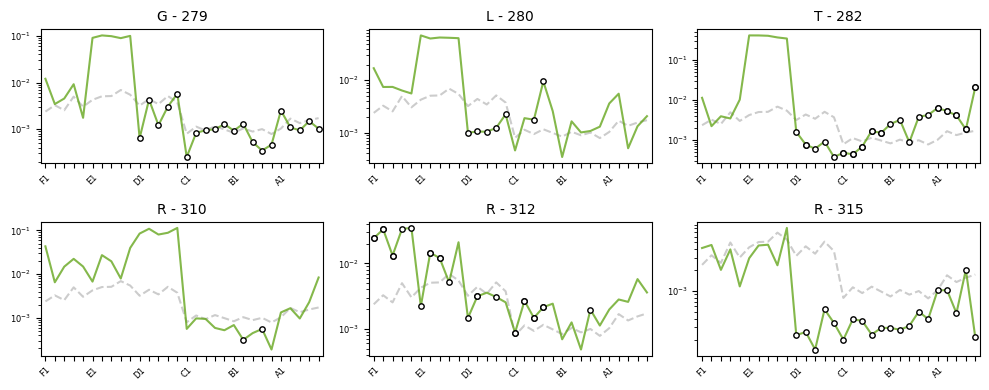

In [88]:
%matplotlib inline
index = 4
fig = plt.figure(figsize=(10, len(interacts_with_res[index]) * 2 // 3), dpi = 100)

c = 1
for i in interacts_with_res[index]:
    if len(interacts_with_res[index]) % 3 == 0:
        ax = fig.add_subplot(len(interacts_with_res[index]) // 3, 3, c) 
    else:
        ax = fig.add_subplot(len(interacts_with_res[index]) // 3 + 1, 3, c) 

    ax.set_yscale("log")
    ax.set_title(residues_code[i] + " - " + str(residues_idx[i]), fontsize = 10)

    ax.plot(residues_energy_med, color = "black", linestyle = "dashed", alpha = 0.2)
    ax.plot(residues_energy_resh[i], alpha = 0.8, color = interacts_with_cmap(index))

    for k in range(3):
        for j in range(residues_energy_resh.shape[1]):
            interaction_list = interactions[i, j, k]
            for l in interaction_list:
                if l[0] in ["U", "V"]:
                    ax.scatter(j, residues_energy_resh[i, j], edgecolor = "black", 
                               color = "white", s = 15, marker = "o", zorder = 3)
                
    ax.set_xticks(range(len(state_chain_names)), 
                  state_chain_names_short, 
                  rotation = 45)
    ax.set_xlim(-0.5, len(state_chain_names)-0.5)
    c += 1

plt.tight_layout()

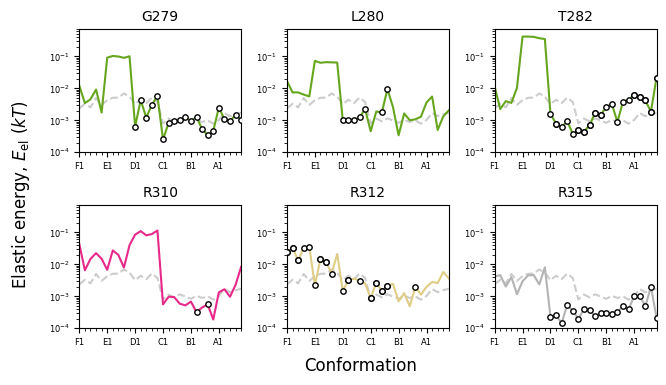

In [90]:
index = 4
fig = plt.figure(figsize=(2*WIDTH, len(interacts_with_res[index]) * 2 // 3), dpi = 100)
fig.supylabel(axis_Eel)
fig.supxlabel("Conformation", x = .54, y = .05)

c = 1
dna_colors = [mech_active_colors[2]] * 3 + [mech_active_colors[1]] + ["#dfcd85", "#b3b3b3"]

for i in interacts_with_res[index]:
    if len(interacts_with_res[index]) % 3 == 0:
        ax = fig.add_subplot(len(interacts_with_res[index]) // 3, 3, c) 
    else:
        ax = fig.add_subplot(len(interacts_with_res[index]) // 3 + 1, 3, c) 

    ax.set_yscale("log")
    ax.set_title(residues_code[i] + str(residues_idx[i]), fontsize = 10)

    ax.plot(residues_energy_med, color = "black", linestyle = "dashed", alpha = 0.2)
    ax.plot(residues_energy_resh[i], alpha = 1, color = dna_colors[c-1])

    for k in range(3):
        for j in range(residues_energy_resh.shape[1]):
            interaction_list = interactions[i, j, k]
            for l in interaction_list:
                if l[0] in ["U", "V"]:
                    ax.scatter(j, residues_energy_resh[i, j], edgecolor = "black", 
                               color = "white", s = 15, marker = "o", zorder = 3)
                
    ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
    ax.set_ylim(1e-4, 7e-1)
    ax.set_xlim(0, 29)

    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.set_xticks(range(0, 30, 5), 
              state_chain_names_short[0:30:5])
    c += 1

plt.tight_layout()

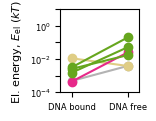

In [91]:
index = 4
fig = plt.figure(figsize = (WIDTH*.3, 1.1), dpi = 100)

ax = fig.add_subplot() 

dna_energy = np.zeros((6, 30))
dna_interaction = np.zeros((6, 30), dtype = bool)
c = 0

for i in interacts_with_res[index]:
    dna_energy[c] = residues_energy_resh[i]
    
    for k in range(3):
        for j in range(residues_energy_resh.shape[1]):
            interaction_list = interactions[i, j, k]
            for l in interaction_list:
                if l[0] in ["U", "V"]:
                    dna_interaction[c, j] = True
                    
    c+=1

dna_colors = [mech_active_colors[2]] * 3 + [mech_active_colors[1]] + ["#dfcd85", "#b3b3b3"]
    
for i in range(6):
    p0 = np.mean(dna_energy[i, dna_interaction[i]])
    p1 = np.mean(dna_energy[i, ~dna_interaction[i]])
    plt.scatter(0, p0, c = dna_colors[i], zorder = -i)
    plt.scatter(1, p1, c = dna_colors[i], zorder = -i)
    plt.plot([0, 1], [p0, p1], c = dna_colors[i], zorder = -i)

    
ax.set_xlim(-.2, 1.2)
ax.set_xticks([0, 1], ["DNA bound", "DNA free"])

ax.set_ylabel(axis_Eel_short)
ax.set_yscale("log")
ax.set_ylim(1e-4, 1e1)
#ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1], [""]*6)
ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1], ["$10^{-4}$", "", "$10^{-2}$", "", "$10^0$", ""])
plt.show()

# Exporting Energies to PDB, encoded on $\beta$-factors

In [92]:
for i in range(1, 6):
    _, labels_CA = load.coordinates(s_pps[i], com_res, labels_hex[i])
    energy_dict = {}
    
    for j in range(6):
        idx = load.chain_indices(chain_names[j], labels_CA)[0]
        
        temp = np.round(residues_energy_resh[:, j*5+i-1], 4)*1e2
        for c, k in enumerate(idx):
            energy_dict[tuple(labels_CA[k][0])] = temp[c]
    
    load.save_bfactor_ca(name = s_names[i], bfact = energy_dict, ext = "_energy", NA = -2.)